# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans  
%matplotlib inline

# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv', ';')

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv', ';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [5]:
azdias.shape

(891221, 85)

In [6]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [7]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,ORTSGR_KLS9,person,ordinal,[-1]
freq,1,43,49,26


In [8]:
attributes = feat_info['attribute']

In [9]:
missing_or_unknown = feat_info['missing_or_unknown']


In [10]:
# azdias[attributes[0]]

In [11]:
azdias['OST_WEST_KZ']

0         NaN
1           W
2           W
3           W
4           W
5           W
6           W
7           W
8           W
9           W
10          W
11        NaN
12          W
13          W
14        NaN
15          W
16          W
17        NaN
18          W
19          W
20          W
21          W
22          W
23          W
24        NaN
25          W
26          W
27          W
28          W
29          W
         ... 
891191      W
891192      W
891193      W
891194      W
891195      W
891196      W
891197      W
891198      W
891199      W
891200      W
891201      W
891202      W
891203      W
891204      W
891205      W
891206      W
891207      W
891208      W
891209      W
891210      W
891211      W
891212      W
891213      W
891214      W
891215      W
891216      W
891217      W
891218      W
891219      W
891220      W
Name: OST_WEST_KZ, Length: 891221, dtype: object

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [12]:
# Identify missing or unknown data values and convert them to NaNs.
for i in range (0,len(attributes)):
    attribute = attributes[i]
    missing = list(missing_or_unknown[i][1:-1].split(','))
    count_missing = 0
    for idx,val in enumerate(azdias[attribute]):
        if str(val) in missing:
#             azdias[attribute].mask(str(azdias[attribute]) in missing)
#             print(azdias.loc[idx, attribute])
#             azdias.loc[idx, attribute]=np.nan
            
#             azdias[attribute][idx] = np.nan
            count_missing+=1
    if count_missing > 0:
        print('Attribute ',attribute,' has ',count_missing," missing values")
        


Attribute  AGER_TYP  has  685843  missing values
Attribute  ALTERSKATEGORIE_GROB  has  2881  missing values
Attribute  GEBURTSJAHR  has  392318  missing values
Attribute  HEALTH_TYP  has  111196  missing values
Attribute  NATIONALITAET_KZ  has  108315  missing values
Attribute  PRAEGENDE_JUGENDJAHRE  has  108164  missing values
Attribute  SHOPPER_TYP  has  111196  missing values
Attribute  VERS_TYP  has  111196  missing values
Attribute  CAMEO_DEUG_2015  has  373  missing values
Attribute  CAMEO_DEU_2015  has  373  missing values
Attribute  CAMEO_INTL_2015  has  373  missing values


In [13]:
for i in range (0,len(attributes)):
    attribute = attributes[i]
    missing = list(missing_or_unknown[i][1:-1].split(','))
    count_missing = 0
    for idx,val in enumerate(missing):
            try:
                int(val)
                azdias[attribute] = azdias[attribute].replace(int(val),np.nan)
            except ValueError:
                azdias[attribute] = azdias[attribute].replace(val,np.nan)  
    


In [14]:
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,NaN,2.0,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,1.0,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,NaN,3.0,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2.0,4.0,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,NaN,3.0,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [15]:
# azdias.drop(columns='AGER_TYP')
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,205378.000000,888340.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,793846.000000,793947.000000,793846.000000
mean,1.743410,2.757217,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.166686,5.293389,3.071033
std,0.674312,1.009951,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,0.999072,2.303379,1.360532
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
25%,1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.000000
50%,2.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.000000
75%,2.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.000000
max,3.000000,4.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,5.000000,9.000000,5.000000


In [16]:
# azdias['OST_WEST_KZ']
# feat_info

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

30% of the total number of values per column is  267366


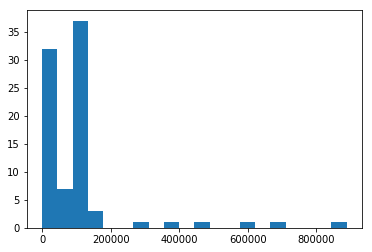

In [17]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

data_missing = azdias.isna().sum()
missing_ratio = int(azdias.shape[0]*0.30)
plt.hist(data_missing, bins=20)

# plt.hist(data_missing)
# print(data_missing.shape)
# print(azdias.shape)
print("30% of the total number of values per column is ",missing_ratio)

In [18]:
dropped = list()
azdias_col_filtered = azdias
for x in data_missing.index:
    if data_missing[x] == 0:
        data_missing = data_missing.drop(x)
    elif data_missing[x] >= missing_ratio:        
        azdias_col_filtered = azdias_col_filtered.drop(columns=x)
        dropped.append(x)
        
# azdias_col_filtered['OST_WEST_KZ']

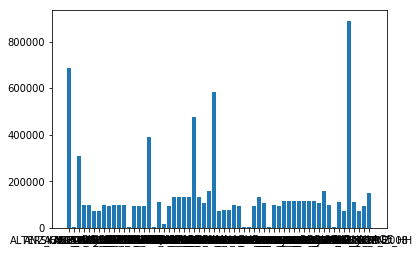

In [19]:
# Investigate patterns in the amount of missing data in each column.

# plt.subplot(131)
plt.bar(data_missing.index, data_missing)
# plt.suptitle('Categorical Plotting')
plt.show()


In [20]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias_col_filtered.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,2,5.0,1,5,2,5,4,5,1,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,2,3.0,1,4,1,2,3,5,1,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2,2.0,4,2,5,2,1,2,6,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,1,5.0,4,3,4,1,3,2,5,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [21]:
print("Number of columns with missing data is ",data_missing.shape[0])
print("Number of columns with missing data less than 30% is ",data_missing.shape[0]-len(dropped))
print("\nColumns dropped are ",dropped)

select_attribute = feat_info.loc[feat_info['attribute'].isin(dropped)]

# feat_info.loc(feat_info['attribute'] == dropped)
print("\n\nDropped columns info \n\n",select_attribute)

Number of columns with missing data is  61
Number of columns with missing data less than 30% is  55

Columns dropped are  ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


Dropped columns info 

        attribute information_level         type missing_or_unknown
0       AGER_TYP            person  categorical             [-1,0]
11   GEBURTSJAHR            person      numeric                [0]
40      TITEL_KZ            person  categorical             [-1,0]
43      ALTER_HH         household     interval                [0]
47  KK_KUNDENTYP         household  categorical               [-1]
64  KBA05_BAUMAX     microcell_rr3        mixed             [-1,0]


#### Discussion 1.1.2: Assess Missing Data in Each Column

Out of the total of 84 colums 61 contains at least one Nan value. Out of these 61 it was noted that 52 have less than 15% of data containig Nan. So the rest 9 columns have more than 15% data as Nan which seems to be outliers so they were dropped.

When looking into the missing data and into the dropped columns it was noted that majority of them were either belonging to personal level or household level information, which makes sense to be Nan as it is not usual to have a lot of personal level information from everyone.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [22]:
# How much data is missing in each row of the dataset?

# print(azdias_col_filtered.describe())

is_NaN = azdias_col_filtered.isnull()

# NaN_count = [col for col in azdias_col_filtered.values]

row_has_NaN = is_NaN.sum(axis=1)

# rows_with_NaN = azdias_col_filtered[row_has_NaN]

# plt.bar(row_has_NaN,76)
# print(row_has_NaN)
# azdias_col_filtered['OST_WEST_KZ']

(array([  6.84502000e+05,   6.26070000e+04,   3.41710000e+04,
          1.10070000e+04,   4.79000000e+03,   7.60000000e+02,
          2.07000000e+02,   2.60000000e+01,   1.79180000e+04,
          1.12000000e+03,   2.78830000e+04]),
 array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
         0.45,  0.5 ,  0.55]),
 <a list of 11 Patch objects>)

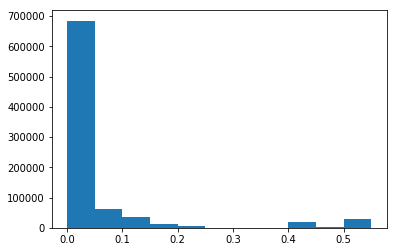

In [23]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.

# print(row_has_NaN)

# above_treshold_data = azdias_col_filtered
# below_treshold_data = azdias_col_filtered



# print(above_treshold_data.head())
# print(below_treshold_data.head())
# print(azdias_col_filtered.isnull().mean(axis=1))
plt.hist(azdias_col_filtered.isnull().mean(axis=1), bins = np.arange(0,0.6,0.05))

In [24]:
treshold = 0.1

print(treshold)

# print(row_has_NaN > treshold)

above_treshold_data = azdias_col_filtered[azdias_col_filtered.isnull().mean(axis=1) > 0.1]
below_treshold_data = azdias_col_filtered[azdias_col_filtered.isnull().mean(axis=1) <= 0.1]

0.1


In [25]:
print(above_treshold_data.shape)
print(below_treshold_data.shape)


above_treshold_data.head()

# below_treshold_data.head()

# azdias

(144112, 79)
(747109, 79)


,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,1,2.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11,2.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
13,1.0,2,5.0,1,4,3,5,5,2,1,...,2.0,1.0,1.0,1.0,1.0,3.0,3.0,3.0,6.0,4.0
14,3.0,1,6.0,3,4,3,5,5,3,4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,4.0,2,4.0,4,1,5,1,1,4,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,8.0,5.0


In [26]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

def compare_rows(attribute, key):
    for i in range (1,key):
        fig = plt.figure(figsize=(20,10))
        ax1 = fig.add_subplot(121)
        ax1.title.set_text('missing above treshold')
        sns.countplot(above_treshold_data[attribute[i]])

        ax2 = fig.add_subplot(122)
        ax2.title.set_text('missing below treshold')
        sns.countplot(below_treshold_data[attribute[i]]);

        fig.suptitle(attribute[i])
        plt.show()
        


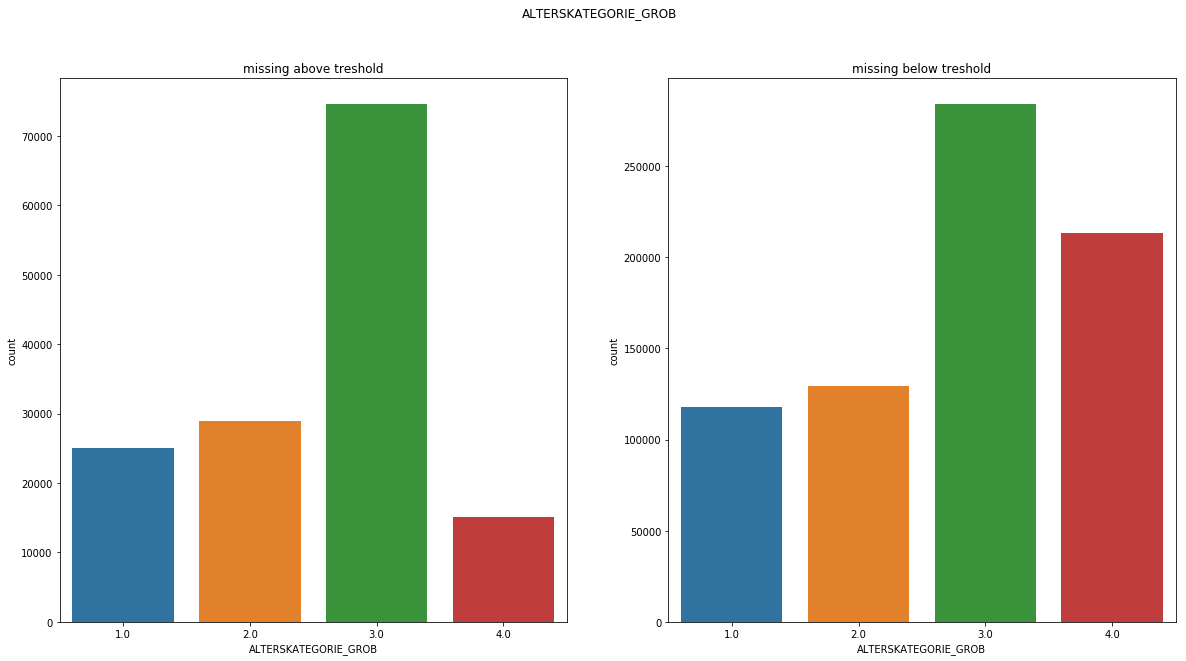

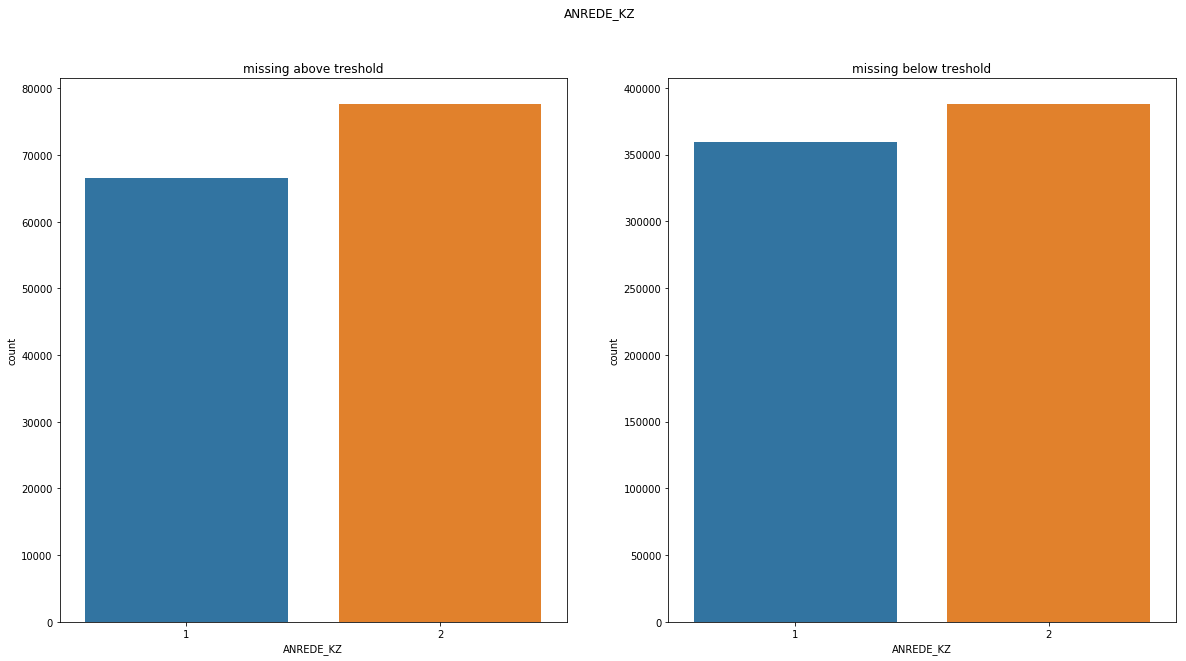

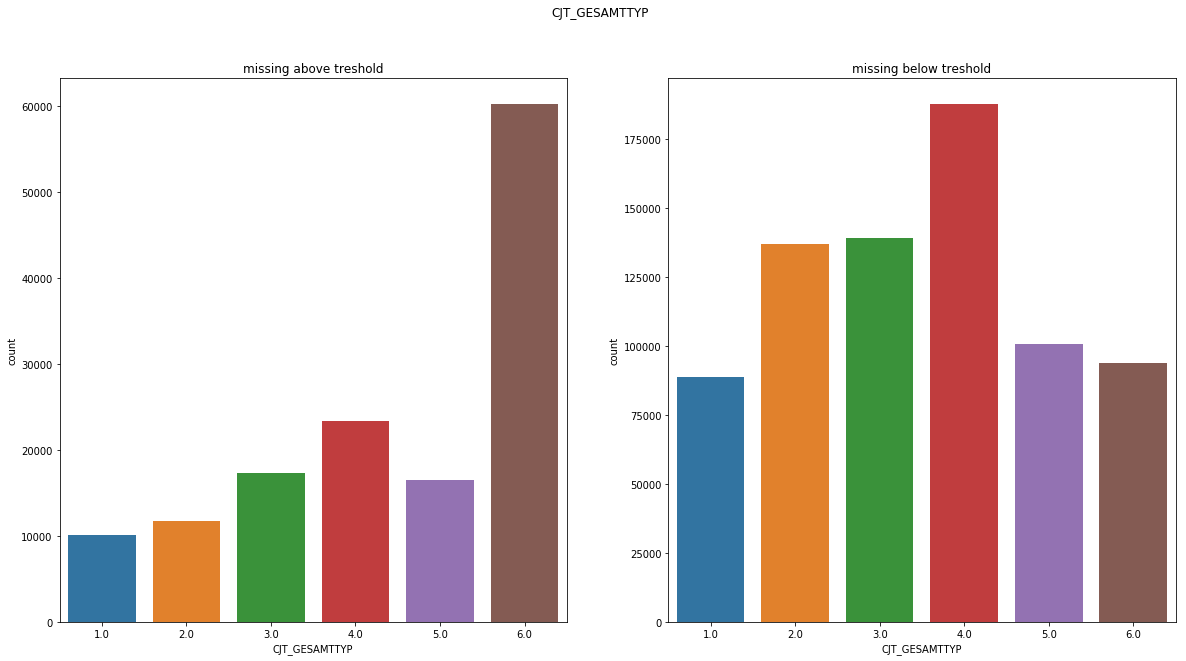

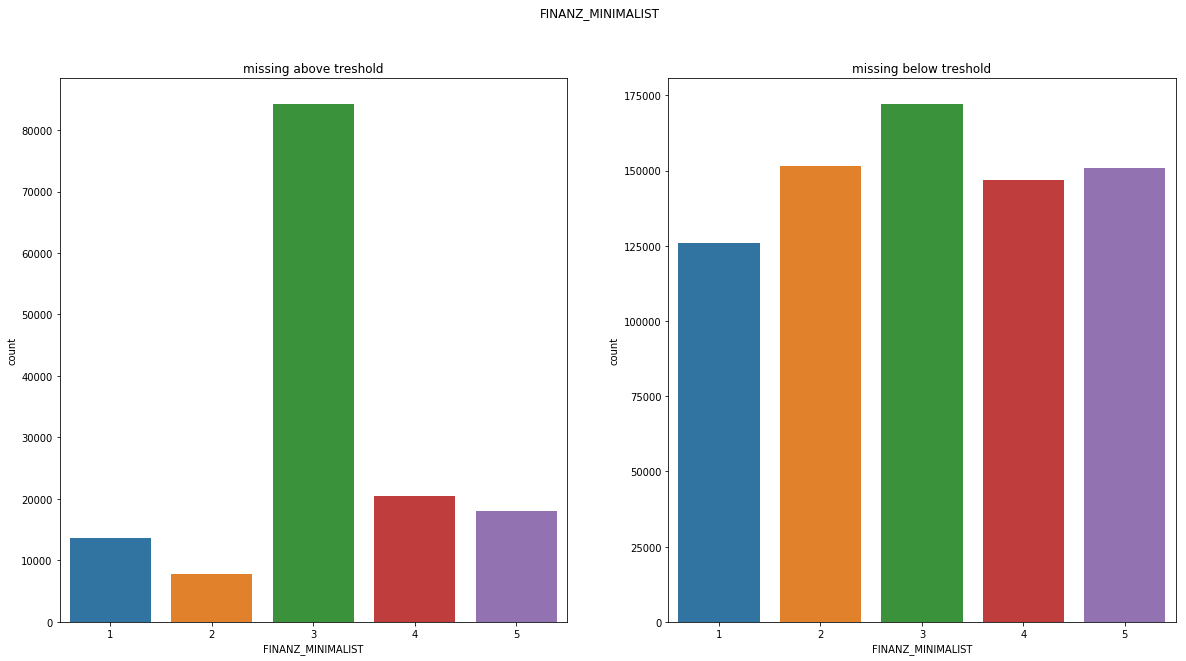

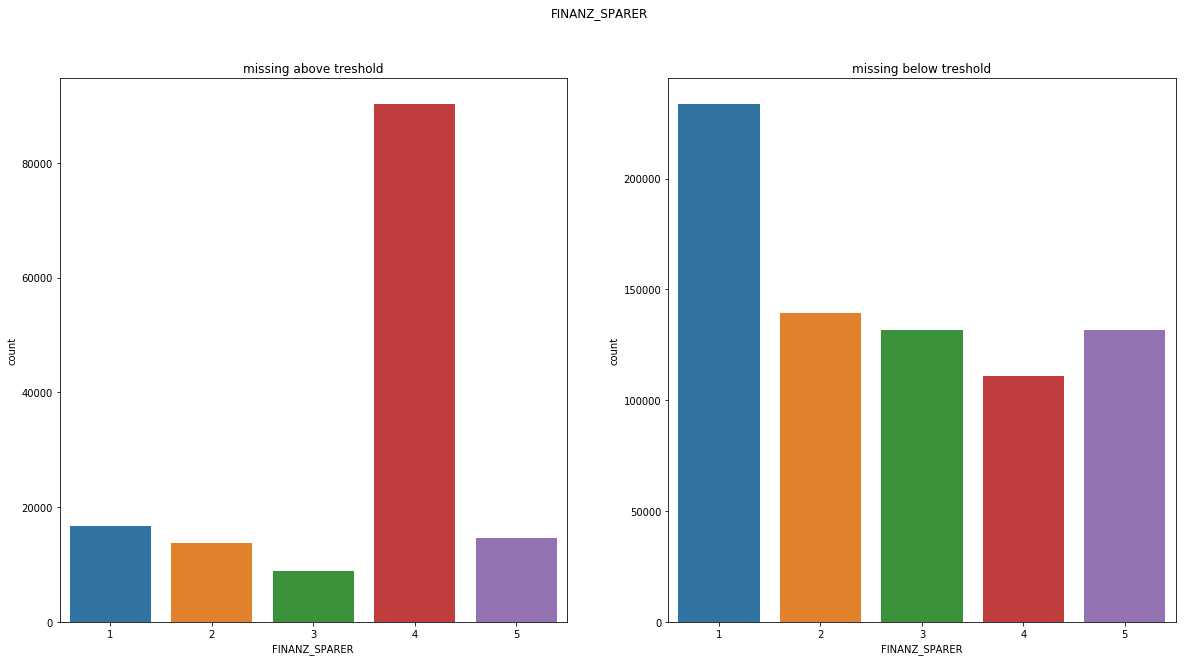

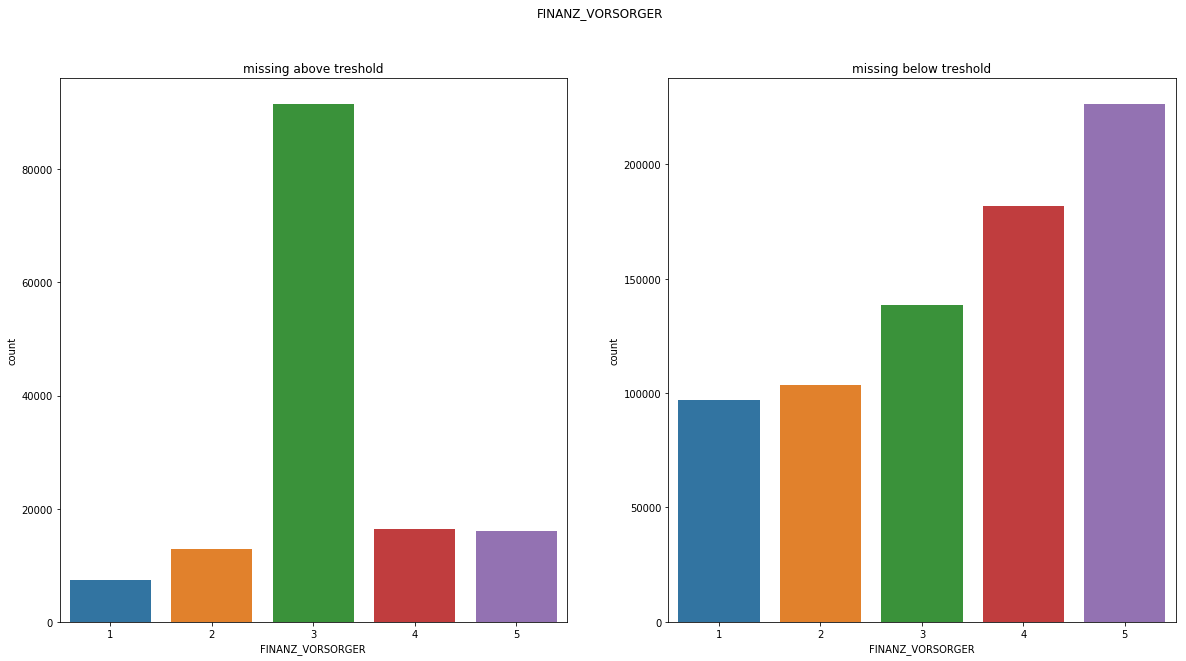

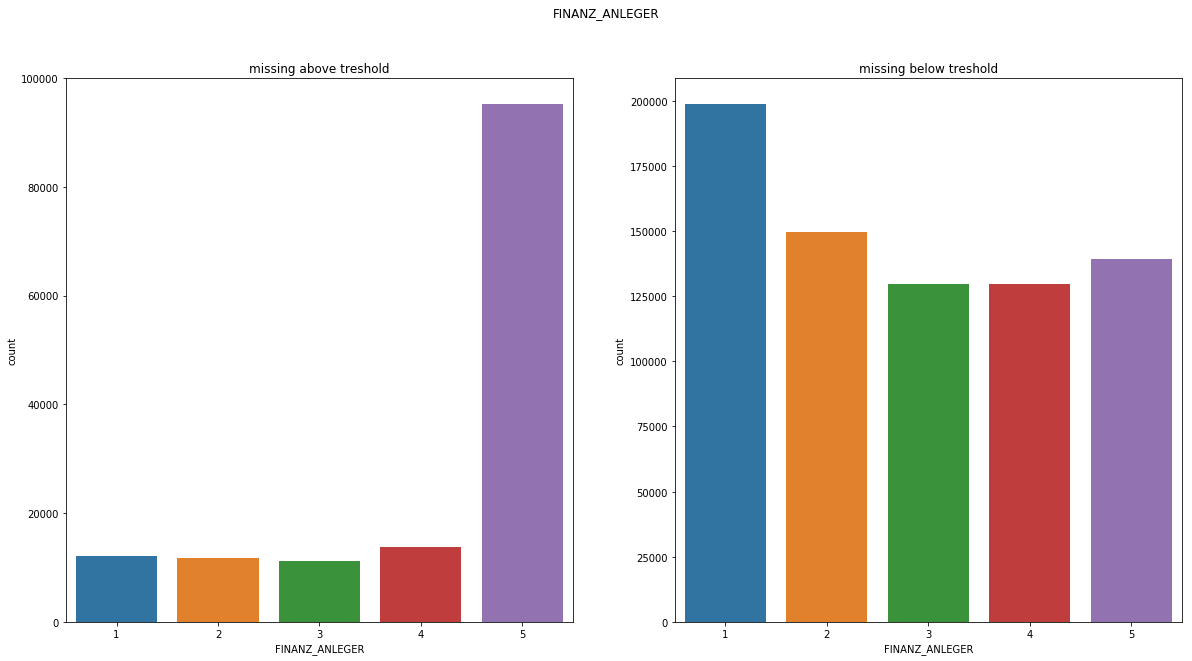

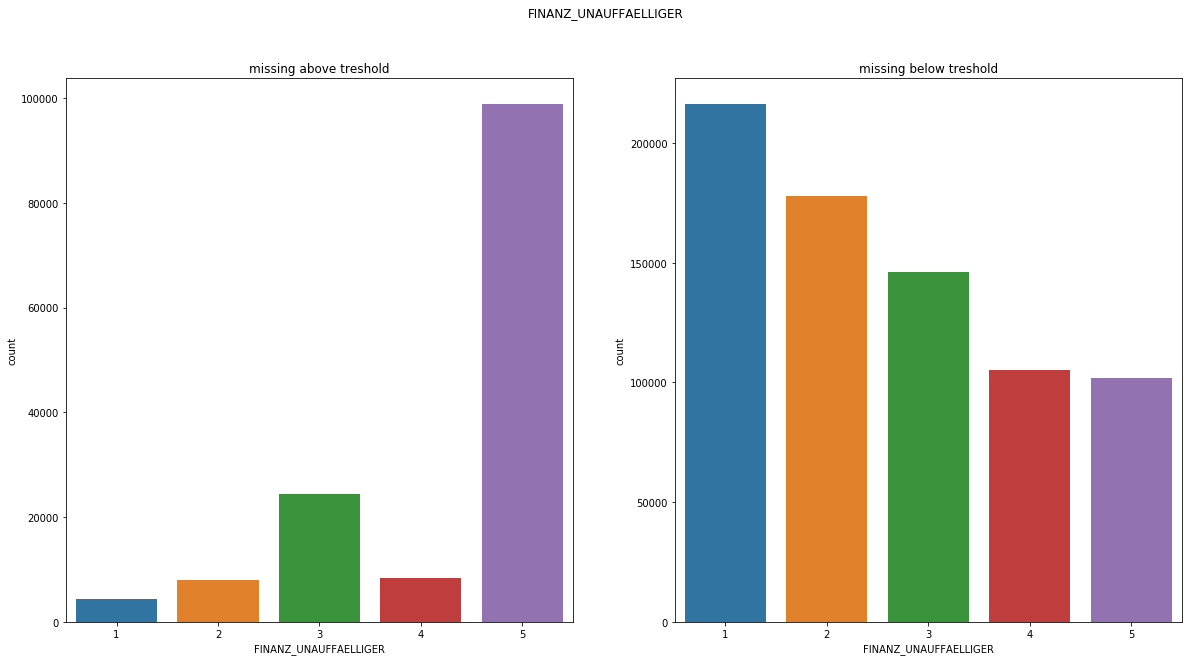

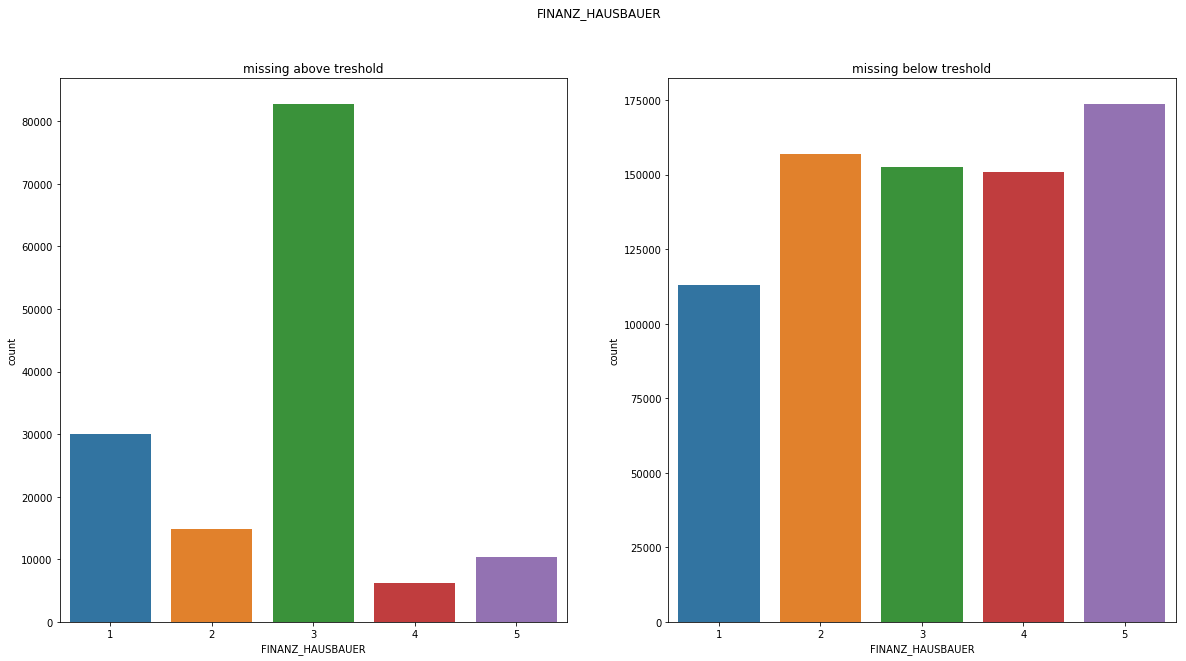

In [27]:
# print(attributes.values == dropped.any())
# print(attributes)
attributes = attributes[~attributes.isin(dropped)]
compare_rows(attributes,10)

#### Discussion 1.1.3: Assess Missing Data in Each Row


The mean of null values in each row is calculated and it can be seen that a big majority of the rows were having a mean between 0-0.1. 144112, rows had the mean NaN values above 0.1 and thus they were removed.

As shown from above graphs the observation for rows mean Nan values above 0.1 is clearly missing the distribution and is either skewed to one of the datapoint or differently distributed and thus it clearly seems to be affecting the analysis in a negative manner.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [28]:
# How many features are there of each data type?
azdias_filtered = below_treshold_data


feat_info_filtered = feat_info.loc[~feat_info['attribute'].isin(dropped)]
print(feat_info_filtered.shape)
print(azdias_filtered.shape)
print(feat_info_filtered.describe())

(79, 4)
(747109, 79)
          attribute information_level     type missing_or_unknown
count            79                79       79                 79
unique           79                 9        4                  9
top     ORTSGR_KLS9            person  ordinal               [-1]
freq              1                40       49                 25


In [29]:
feat_info_type_count = feat_info_filtered.groupby('type').count()
feat_info_type_count



,attribute,information_level,missing_or_unknown
type,,,
categorical,18,18,18
mixed,6,6,6
numeric,6,6,6
ordinal,49,49,49


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [30]:
# Re-encode categorical variable(s) to be kept in the analysis.

feat_info_group = feat_info_filtered.groupby('type')
feat_info_categorical = feat_info_group.indices['categorical']



feat_categorical = feat_info_filtered.iloc[feat_info_categorical]

feat_categorical['attribute'].values

azdias_categorical = azdias_filtered[feat_categorical['attribute'].values]

azdias_categorical

categorical_binary = []
categorical_multiple = []

for data in azdias_categorical:
    if azdias_categorical[data].nunique() > 2:
        categorical_multiple.append(data)
#         print(azdias_filtered[data].value_counts())
    else:
        categorical_binary.append(data)
        azdias_filtered[data].replace(azdias_filtered[data].value_counts().index, [1,0], inplace=True)
        
        
azdias_filtered = pd.get_dummies(azdias_filtered, columns=categorical_multiple)

print(categorical_binary)
print(categorical_multiple)


/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ']
['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [31]:
categorical_multiple

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

In [32]:
azdias_filtered.shape

(747109, 194)

#### Discussion 1.2.1: Re-Encode Categorical Features



It is necessary for the data to be i numeric form to be in a consistent and learnable form by the model.

Also if the data is converted to one-hot encoding it makes sure that the data is normalized and does not give higher weight to  a perticular feature. 

In categorical features the binary ones were turned to 0,1

The multiple ones were converted to dummies and thus the total features are 191

The same goes for data in non-numerical data as the meaning of re-encoding is to have a consistant numerical data.

Non-numerical columns having binary values like 'X' and 'XX' will be converted to 0,1 and consisting of more than 2 values are converted to dummies.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [33]:
feat_info_group = feat_info_filtered.groupby('type')
feat_info_mixed = feat_info_group.indices['mixed']



feat_mixed = feat_info_filtered.iloc[feat_info_mixed]

feat_mixed = feat_mixed.loc[~feat_mixed.attribute.isin(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'])]

# feat_mixed.drop(feat_mixed.values == 'PRAEGENDE_JUGENDJAHRE')

# yourdf.drop(['columnheading1', 'columnheading2'], axis=1, inplace=True)
azdias_filtered.drop(feat_mixed.attribute, axis=1, inplace=True)

In [34]:
azdias_filtered.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,CAMEO_DEU_2015_7E,CAMEO_DEU_2015_8A,CAMEO_DEU_2015_8B,CAMEO_DEU_2015_8C,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E
1,1.0,1,1,5,2,5,4,5,1,3.0,...,0,1,0,0,0,0,0,0,0,0
2,3.0,1,1,4,1,2,3,5,0,3.0,...,0,0,0,0,0,0,0,0,0,0
3,4.0,1,4,2,5,2,1,2,1,2.0,...,0,0,0,0,0,0,0,0,0,0
4,3.0,0,4,3,4,1,3,2,1,3.0,...,0,0,0,0,0,0,0,0,0,0
5,1.0,1,3,1,5,2,2,5,1,3.0,...,0,0,0,1,0,0,0,0,0,0


In [35]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

# print(azdias_filtered['PRAEGENDE_JUGENDJAHRE'].describe())
# print(azdias_filtered['PRAEGENDE_JUGENDJAHRE'])

feat_info_filtered.where(feat_info_filtered['attribute'] == 'PRAEGENDE_JUGENDJAHRE')

def transform(data):
    try:
        if binary:
            
            if pd.isnull(data):
                return np.nan
            else:
                if move:
                    
                    return int(str(data)[0])
                else:
                    return int(str(data)[1])
        else:
            for key, val in dummies.items():
                if data in val:
                    return key
    except ValueError:
        return np.nan
    
decade = {0: [1, 2], 1: [3, 4, 5], 2: [6, 7], 3: [8, 9, 10], 4: [11, 12, 13], 5:[14, 15]}
movement = {0:[1, 3, 5, 8, 10, 12, 14], 1:[2,4,6,7,9,11,13,15]}

dummies = decade
binary = False
azdias_filtered['PRAEGENDE_JUGENDJAHRE_decade'] = azdias_filtered['PRAEGENDE_JUGENDJAHRE'].apply(transform)

dummies = movement
azdias_filtered['PRAEGENDE_JUGENDJAHRE_movement'] = azdias_filtered['PRAEGENDE_JUGENDJAHRE'].apply(transform)


binary = True
move = True
azdias_filtered['CAMEO_INTL_2015_wealth'] = azdias_filtered['CAMEO_INTL_2015'].apply(transform)
move = False
# Create life stage column
azdias_filtered['CAMEO_INTL_2015_lifestage'] = azdias_filtered['CAMEO_INTL_2015'].apply(transform)



    

In [36]:
azdias_filtered[['CAMEO_INTL_2015','CAMEO_INTL_2015_wealth','CAMEO_INTL_2015_lifestage']]


,CAMEO_INTL_2015,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
1,51,5.0,1.0
2,24,2.0,4.0
3,12,1.0,2.0
4,43,4.0,3.0
5,54,5.0,4.0
6,22,2.0,2.0
7,14,1.0,4.0
8,13,1.0,3.0
9,15,1.0,5.0
10,51,5.0,1.0


In [37]:
azdias_filtered[['PRAEGENDE_JUGENDJAHRE','PRAEGENDE_JUGENDJAHRE_decade','PRAEGENDE_JUGENDJAHRE_movement']]


,PRAEGENDE_JUGENDJAHRE,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement
1,14.0,5.0,0.0
2,15.0,5.0,1.0
3,8.0,3.0,0.0
4,8.0,3.0,0.0
5,3.0,1.0,0.0
6,10.0,3.0,0.0
7,8.0,3.0,0.0
8,11.0,4.0,1.0
9,15.0,5.0,1.0
10,3.0,1.0,0.0


In [38]:
azdias_filtered = azdias_filtered.drop(columns = 'PRAEGENDE_JUGENDJAHRE')

In [39]:
azdias_filtered = azdias_filtered.drop(columns = 'CAMEO_INTL_2015')

In [40]:


azdias_filtered.shape

(747109, 192)

#### Discussion 1.2.2: Engineer Mixed-Type Features

For mixed features other than PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 they were not crucial for the analysis and removed from the data

PRAEGENDE_JUGENDJAHRE and CAMEO_INTL_2015 were Converted according to dictionary.

For PRAEGENDE_JUGENDJAHRE_decade: 0: [1, 2], 1: [3, 4, 5], 2: [6, 7], 3: [8, 9, 10], 4: [11, 12, 13], 5:[14, 15]
For PRAEGENDE_JUGENDJAHRE_movement: 0:[1, 3, 5, 8, 10, 12, 14], 1:[2,4,6,7,9,11,13,15]

For CAMEO_INTL_2015_wealth: first num

For CAMEO_INTL_2015_wealth: second num


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [41]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

#Done

In [42]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

#Done

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [43]:
gen_dict = {0: [1, 2], 1: [3, 4, 5], 2: [6, 7], 3: [8, 9, 10], 4: [11, 12, 13], 5:[14, 15]}
mainstream = {0:[1, 3, 5, 8, 10, 12, 14]}


def map_gen(x):
    try:
        for key, array in gen_dict.items():
            if x in array:
                return key
    except ValueError:
        return np.nan
    
# Map movement 
mainstream = [1, 3, 5, 8, 10, 12, 14]

def map_mov(x):
    try:
        if x in mainstream:
            return 0
        else:
            return 1
    except ValueError:
        return np.nan
    
    
def map_wealth(x):
    # Check of nan first, or it will convert nan to string 'nan'
#     print(x)
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[0])

# Map life stage
def map_lifestage(x):
    if pd.isnull(x):
        return np.nan
    else:
        return int(str(x)[1])

In [44]:
gen_dict = {0: [1, 2], 1: [3, 4, 5], 2: [6, 7], 3: [8, 9, 10], 4: [11, 12, 13], 5:[14, 15]}
mainstream = {0:[1, 3, 5, 8, 10, 12, 14], 1:[2,4,6,7,9,11,13,15]}
    
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    
    missing_or_unknown = feat_info['missing_or_unknown']
    attributes = feat_info['attribute']
    
    
    for i in range (0,len(attributes)):
        attribute = attributes[i]
        missing = list(missing_or_unknown[i][1:-1].split(','))
        count_missing = 0
        for idx,val in enumerate(missing):
            try:
                int(val)
                df[attribute] = df[attribute].replace(int(val),np.nan)
            except ValueError:
                df[attribute] = df[attribute].replace(val,np.nan)  
            
            
    df_col_filtered = df.drop(dropped, axis=1)
            
    is_NaN = df_col_filtered.isnull()

    row_has_NaN = is_NaN.sum(axis=1)
    
    df_filtered = df_col_filtered[df_col_filtered.isnull().mean(axis=1) <= 0.1]
    
    
    
    # select, re-encode, and engineer column values.
    
    feat_info_filtered = feat_info.loc[~feat_info['attribute'].isin(dropped)]

    feat_info_group = feat_info_filtered.groupby('type')
    feat_info_categorical = feat_info_group.indices['categorical']

    feat_info_mixed = feat_info_group.indices['mixed']

    feat_mixed = feat_info_filtered.iloc[feat_info_mixed]

    feat_mixed = feat_mixed.loc[~feat_mixed.attribute.isin(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'])]

    df_filtered.drop(feat_mixed.attribute, axis=1, inplace=True)
    
    print(df_filtered.shape)
    
    

    feat_categorical = feat_info_filtered.iloc[feat_info_categorical]
    
    print(feat_categorical)

#     feat_categorical['attribute'].values

    df_categorical = df_filtered[feat_categorical['attribute'].values]

    categorical_binary = []
    categorical_multiple = []

    for data in df_categorical:
        if df_categorical[data].nunique() > 2:
            categorical_multiple.append(data)
        else:
            categorical_binary.append(data)
            df_filtered[data].replace(df_filtered[data].value_counts().index, [1,0], inplace=True)


    df_filtered = pd.get_dummies(df_filtered, columns=categorical_multiple)
    
    df_filtered['PRAEGENDE_JUGENDJAHRE_decade'] = df_filtered['PRAEGENDE_JUGENDJAHRE'].apply(map_gen)
    
    df_filtered['PRAEGENDE_JUGENDJAHRE_movement'] = df_filtered['PRAEGENDE_JUGENDJAHRE'].apply(map_mov)
    
    df_filtered['CAMEO_INTL_2015_wealth'] = df_filtered['CAMEO_INTL_2015'].apply(map_wealth)

    df_filtered['CAMEO_INTL_2015_lifestage'] = df_filtered['CAMEO_INTL_2015'].apply(map_lifestage)
    

    df_filtered = df_filtered.drop(columns = 'PRAEGENDE_JUGENDJAHRE')
    df_filtered = df_filtered.drop(columns = 'CAMEO_INTL_2015')
    
    
    return df_filtered

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [45]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

from sklearn.preprocessing import Imputer, StandardScaler

filtered = azdias_filtered

imputer = Imputer(strategy='mean')
filtered = imputer.fit_transform(filtered)

In [46]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
standardized_features = scaler.fit_transform(filtered)

### Discussion 2.1: Apply Feature Scaling


Used mean Imputer with standard scaling function 

StandardScaler was used as it brings the data to a same range with mean 0 and std dev 1

Imputer was used with mean to replace Nan which I think will make the data to stay in similar range but mode or 0 can also be added which 0 adds much more noise to data compaired to other two. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [47]:
# Apply PCA to the data.

pca = PCA(10)
pca_features = pca.fit_transform(standardized_features)

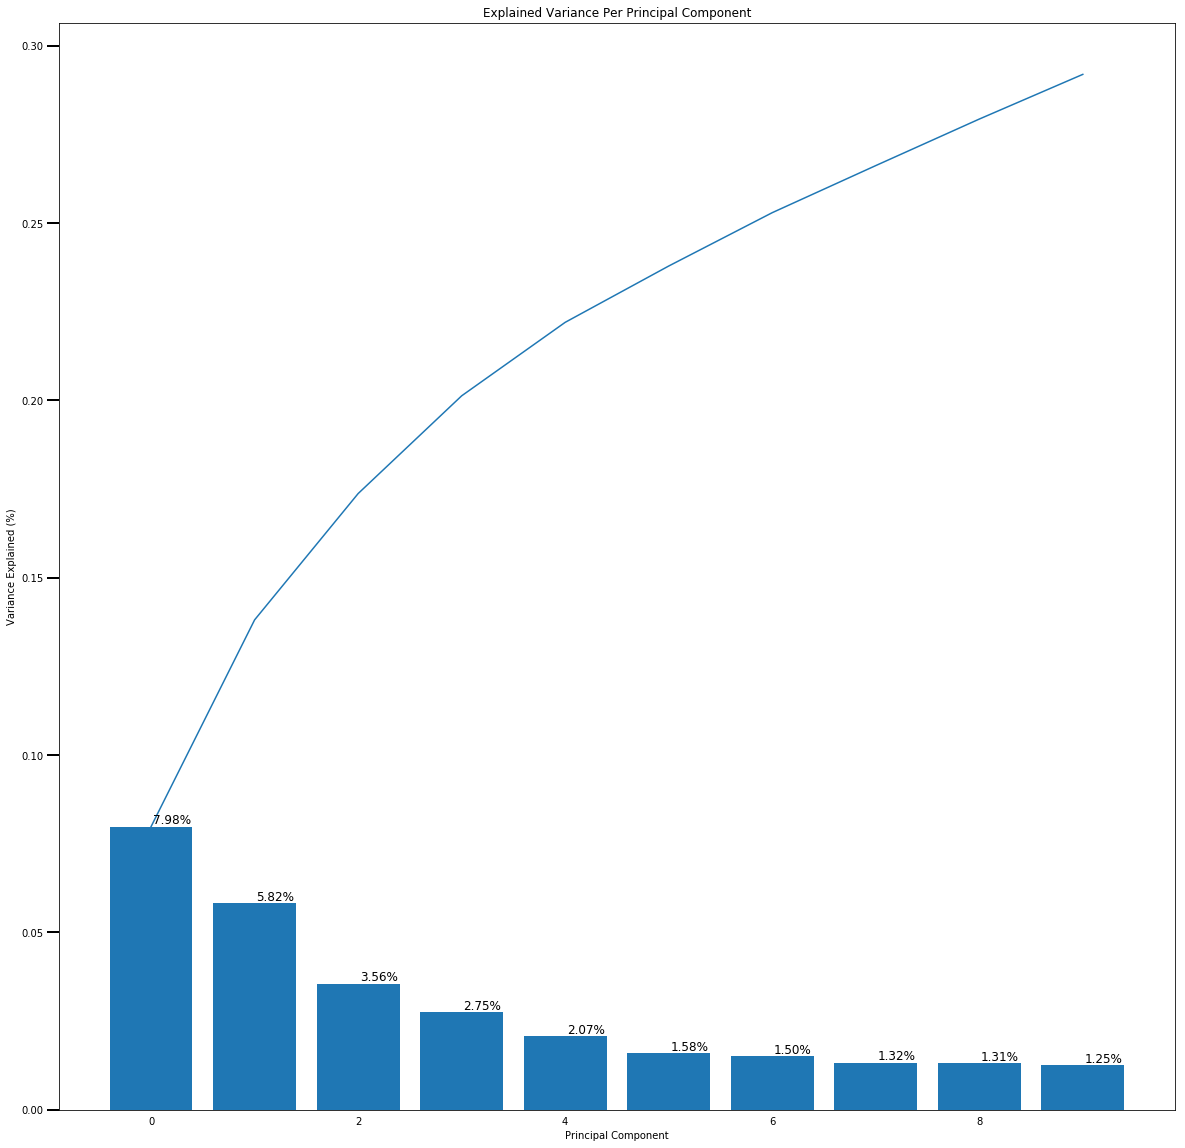

In [48]:
# Investigate the variance accounted for by each principal component.
from helper_functions import scree_plot,do_pca,pca_results
# Udacity helper file for pca functions

scree_plot(pca)


In [49]:
# Re-apply PCA to the data while selecting for number of components to retain.


pca = PCA(192)

pca_features = pca.fit_transform(standardized_features)


    
    

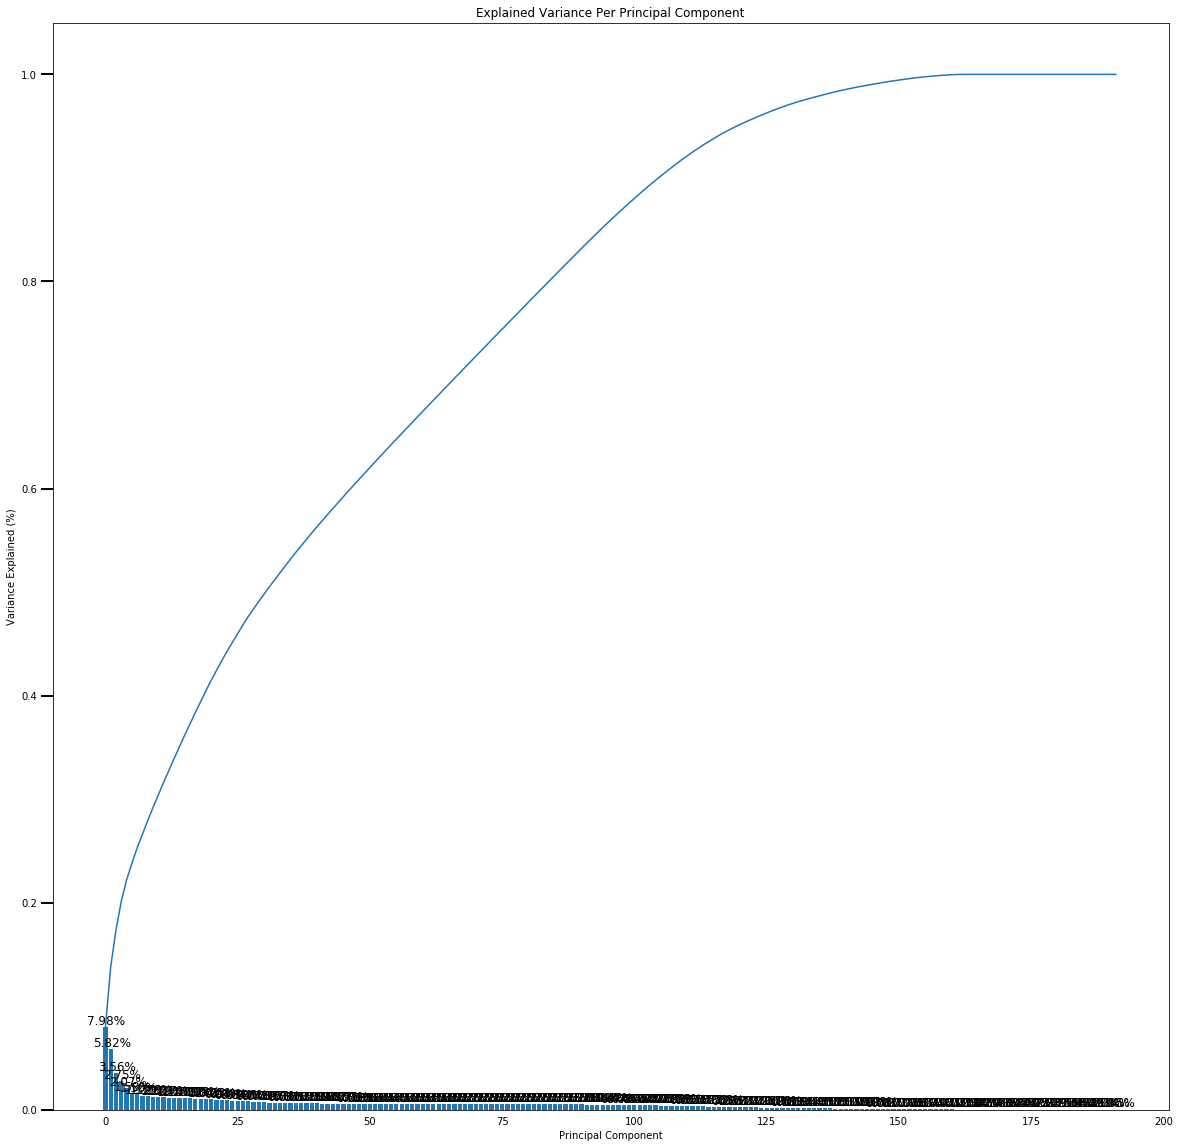

In [50]:
scree_plot(pca)

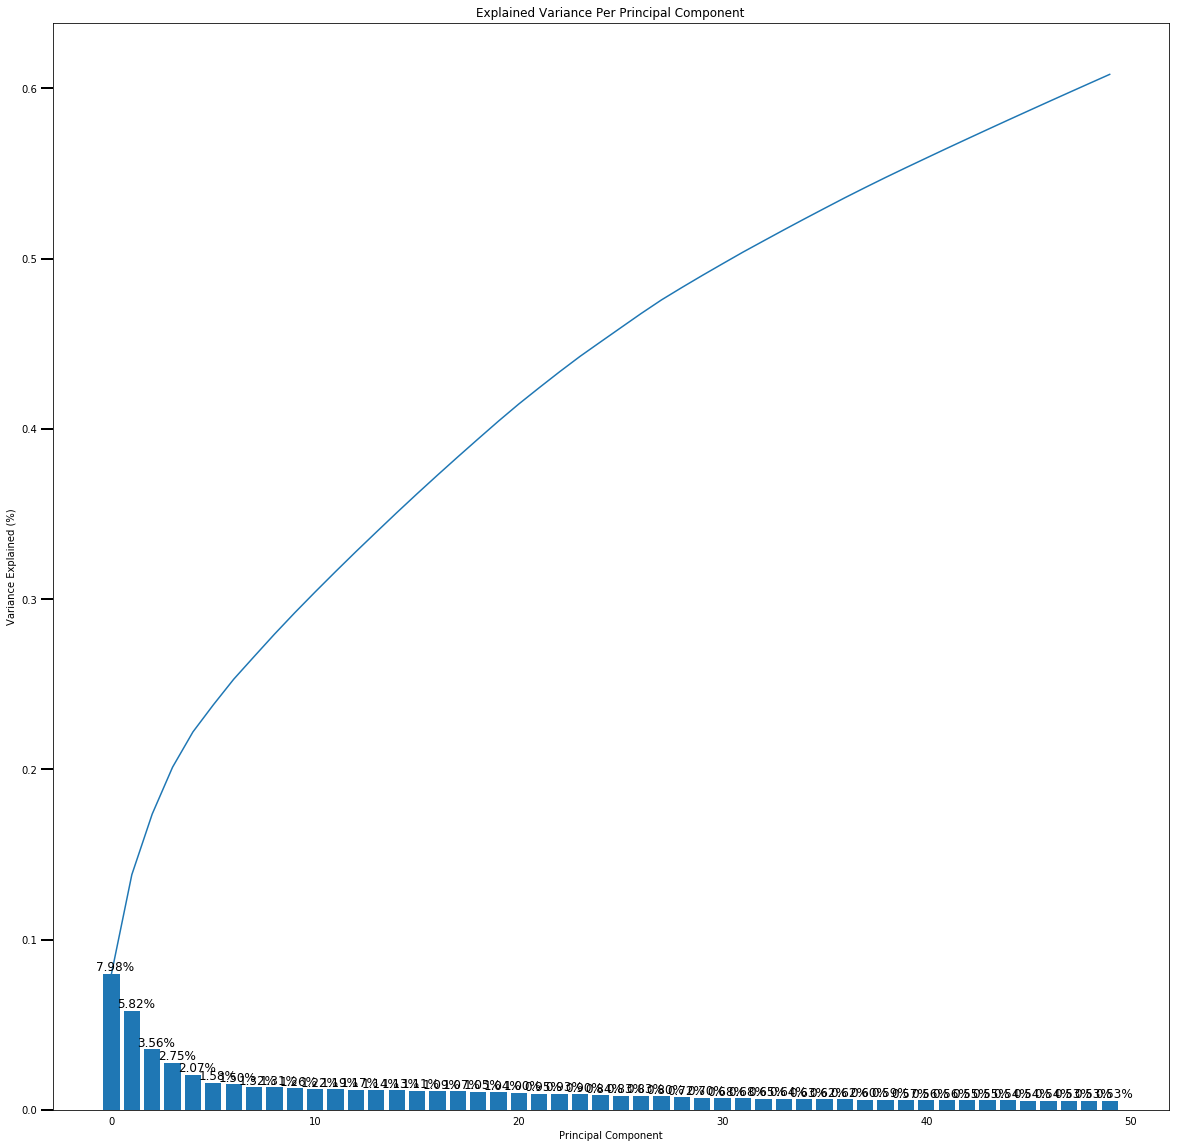

In [51]:
pca = PCA(50)

pca_features = pca.fit_transform(standardized_features)

scree_plot(pca)
    

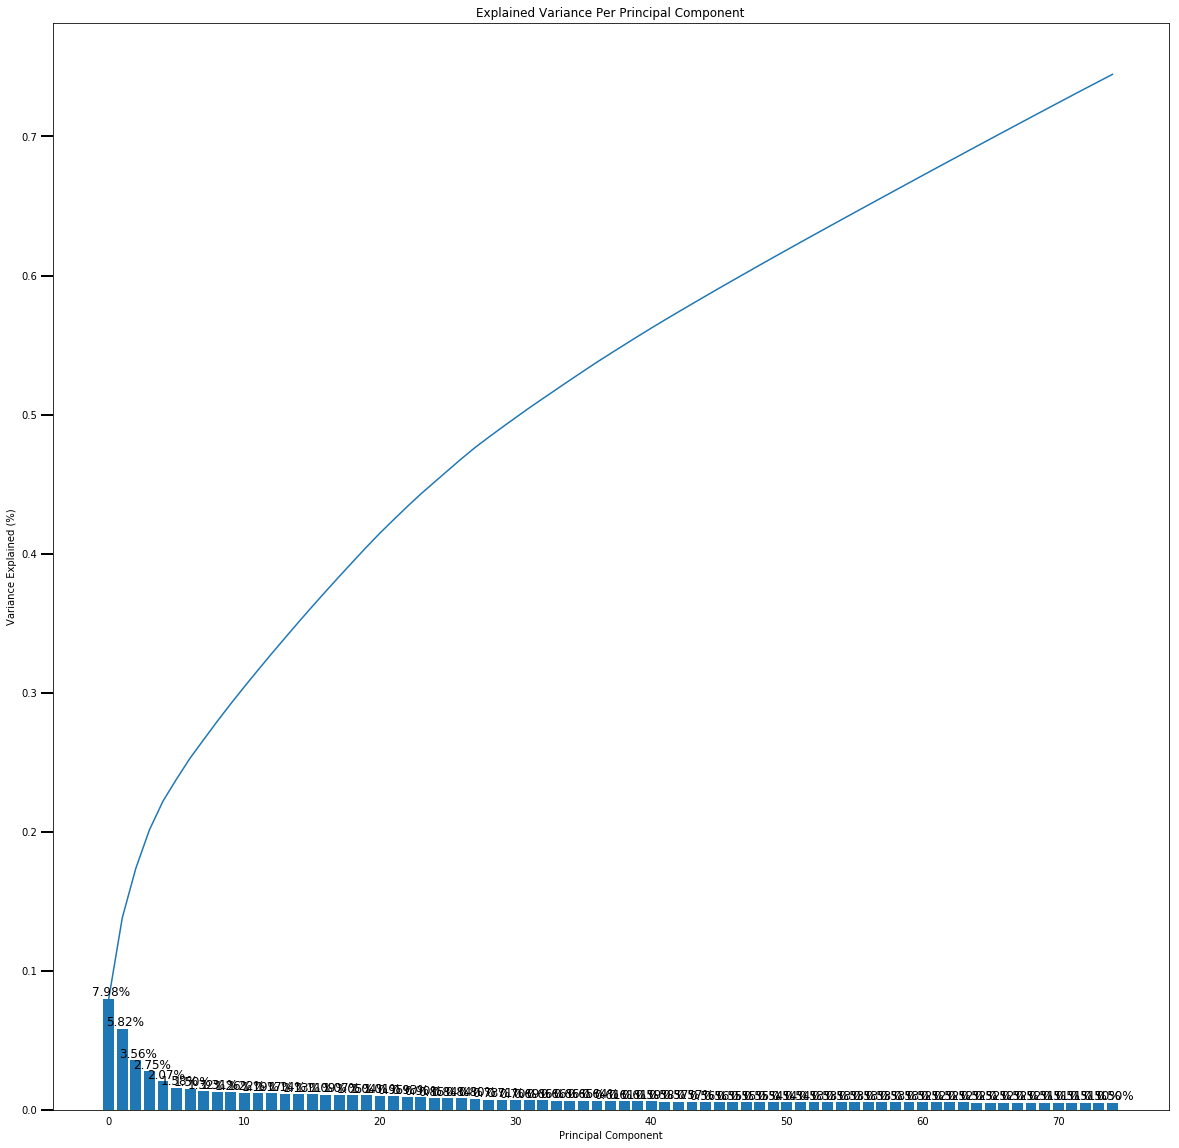

In [52]:
pca = PCA(75)

pca_features = pca.fit_transform(standardized_features)

scree_plot(pca)

### Discussion 2.2: Perform Dimensionality Reduction



While the overall graph of 192 features shows that the curve starts to get flatten by about 120 components but it can be observed that after about 70 components there is not much change and it covers more than 70% of variance that is why 75 components are used

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [53]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

    

,Explained Variance,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,...,CAMEO_DEU_2015_8D,CAMEO_DEU_2015_9A,CAMEO_DEU_2015_9B,CAMEO_DEU_2015_9C,CAMEO_DEU_2015_9D,CAMEO_DEU_2015_9E,PRAEGENDE_JUGENDJAHRE_decade,PRAEGENDE_JUGENDJAHRE_movement,CAMEO_INTL_2015_wealth,CAMEO_INTL_2015_lifestage
Dimension 1,0.0798,-0.0904,0.0122,-0.1924,0.1182,-0.0884,0.0569,0.0567,0.1458,0.1069,...,0.0252,0.0387,0.0572,0.0575,0.0579,0.0159,0.0736,-0.1058,0.1855,-0.1117
Dimension 2,0.0583,0.2314,0.0409,0.0833,-0.2246,0.2163,-0.2025,-0.2129,0.0888,0.0139,...,0.0357,-0.0051,0.0039,0.0083,0.0141,0.0377,-0.2334,-0.0124,0.0627,0.0066
Dimension 3,0.0356,0.0190,-0.3451,0.1303,-0.0550,0.0478,-0.1541,-0.0438,-0.0632,-0.0768,...,-0.0003,-0.0042,0.0124,0.0259,0.0112,-0.0011,-0.0468,0.0758,0.0165,-0.0149


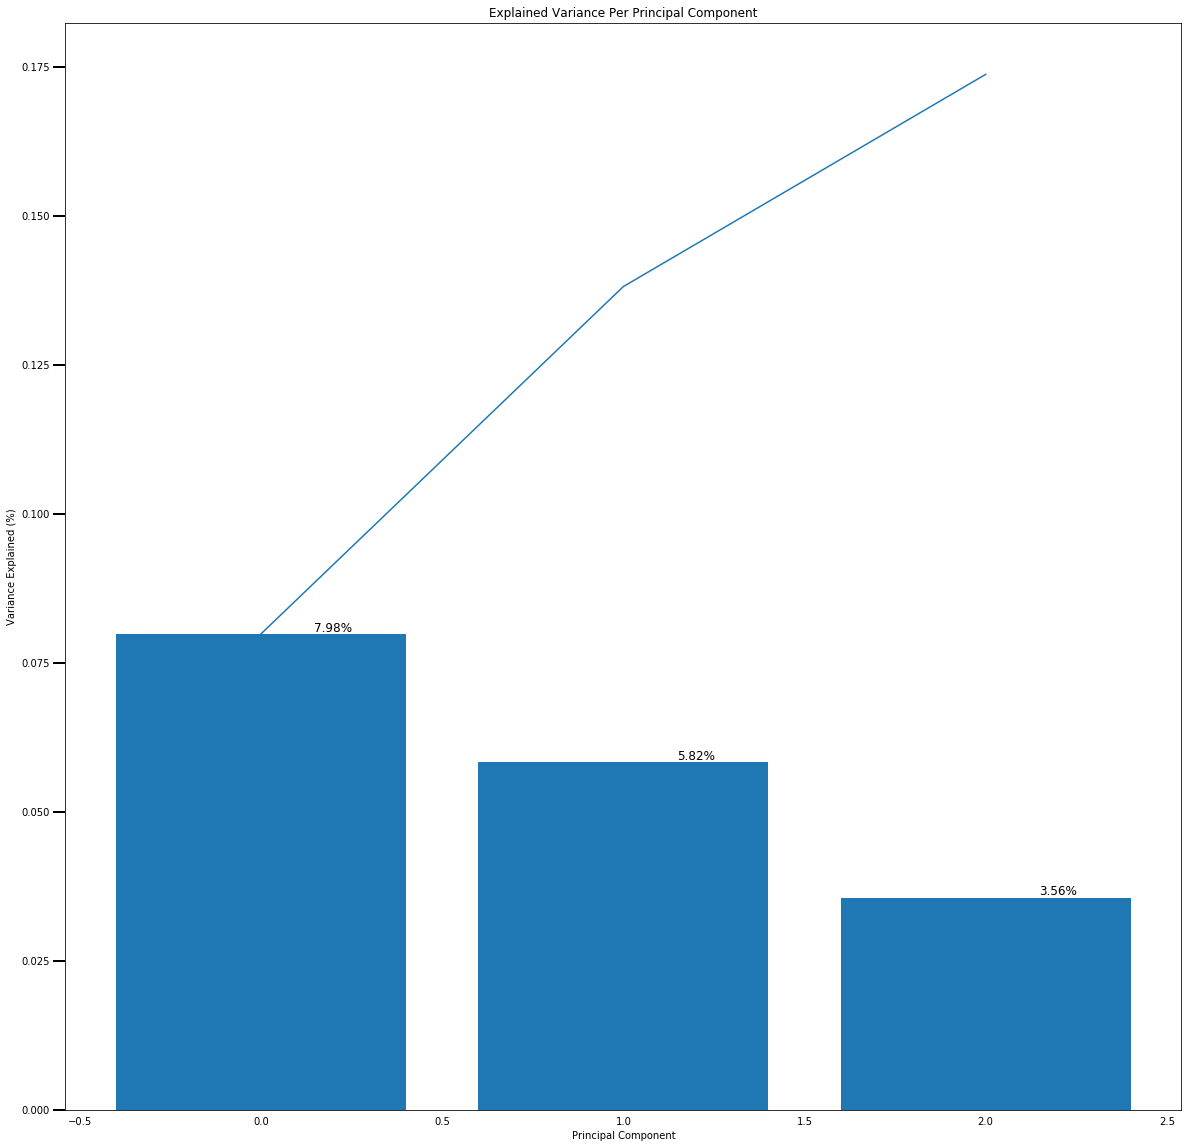

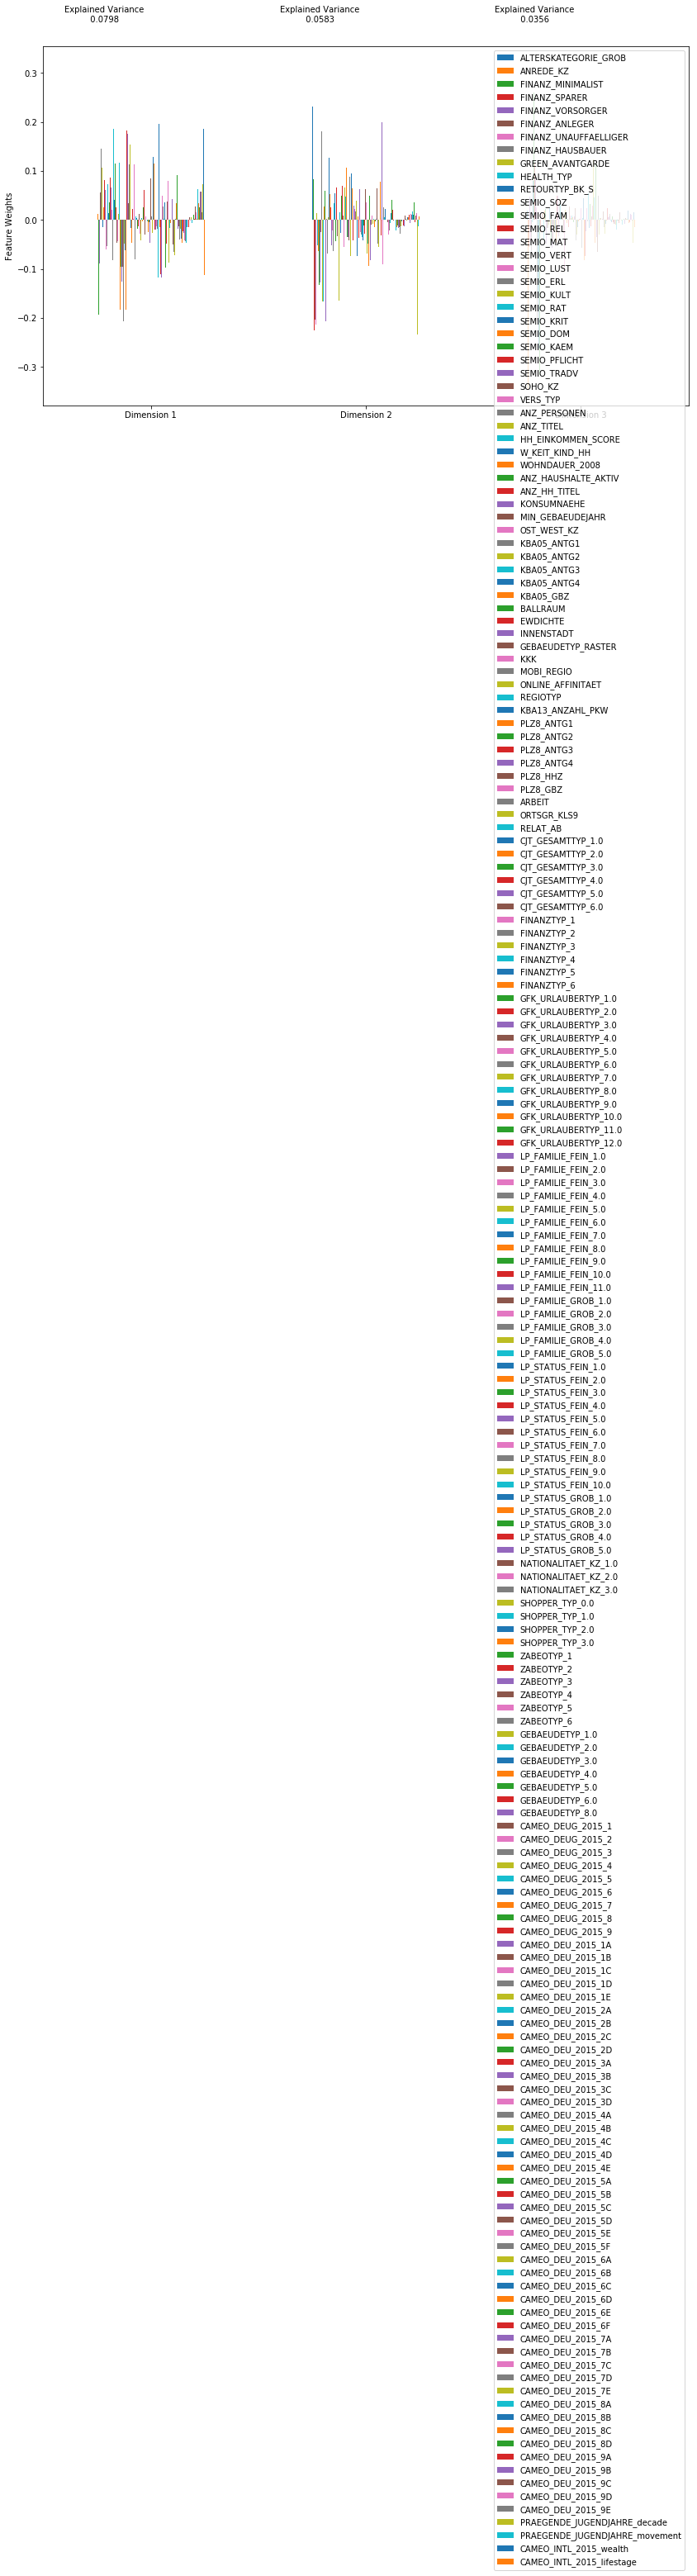

In [54]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.


pca_int = PCA(3)

pca_features = pca_int.fit_transform(standardized_features)

scree_plot(pca_int)

pca_results(azdias_filtered, pca_int)



In [57]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
def pca_result_component(df,pca,component_id):
    
    component = pd.DataFrame(np.round(pca.components_, 4), columns = df.keys()).iloc[component_id-1]
    component.sort_values(ascending=False, inplace=True)
    component = pd.concat([component.head(10), component.tail(10)])
    
    com = list(component.index)
    print("\n".join(com))
#     print(com)
#     df.loc[df['column_name'].isin(some_values)]
#     print(feat_info_filtered.loc[feat_info_filtered['attribute'].isin(com)])
    component.plot(kind='bar', title='Component ' + str(component_id))
    ax = plt.gca()
    ax.grid(linewidth='0.5', alpha=0.5)
    ax.set_axisbelow(True)
    plt.show()


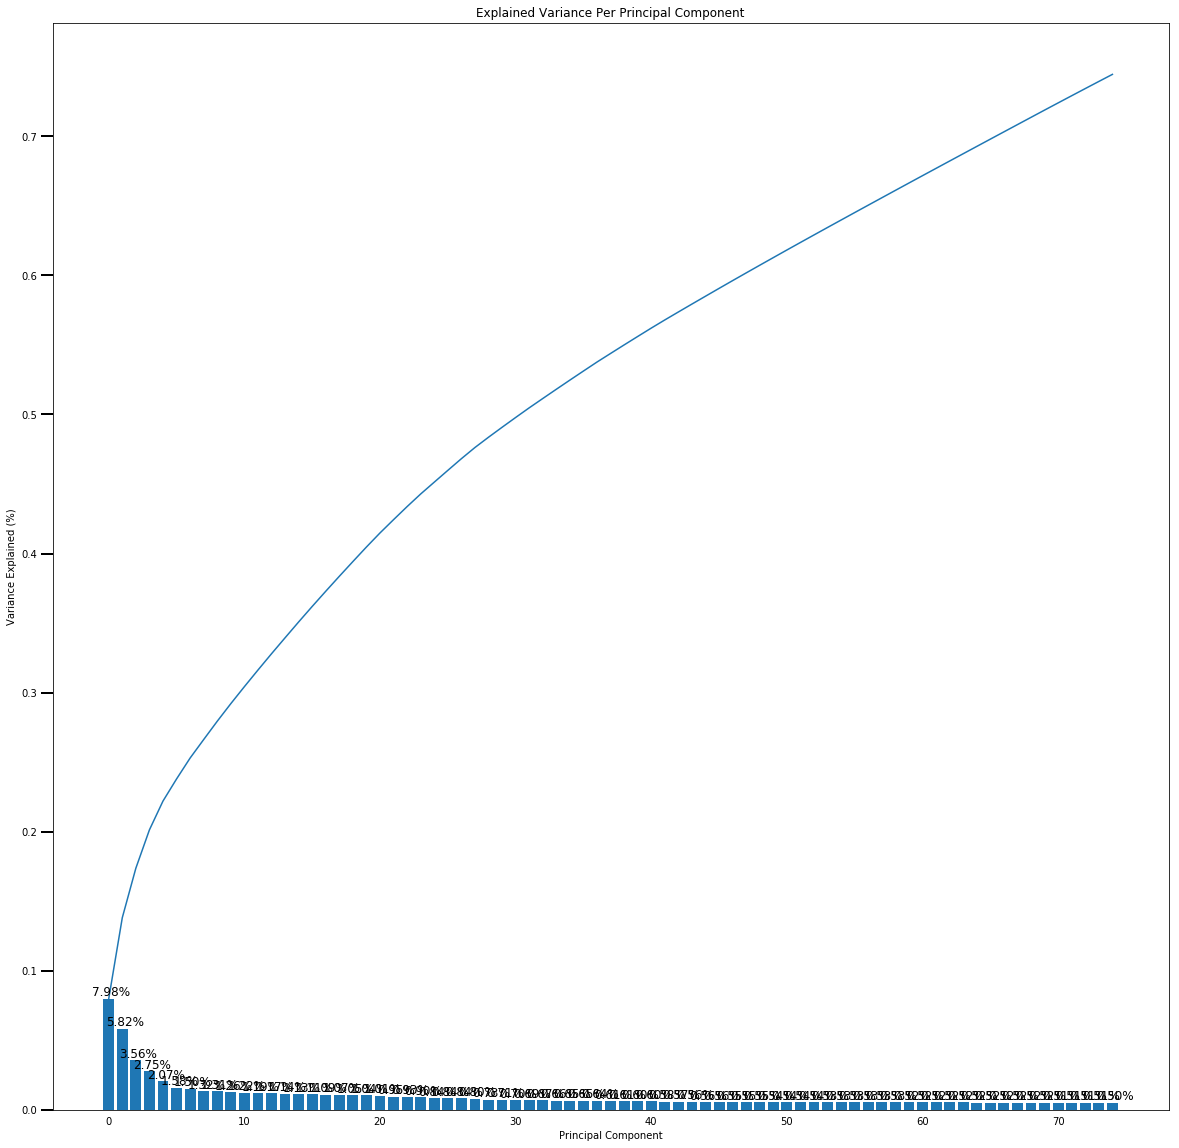

In [72]:
pca = PCA(75)

pca_features = pca.fit_transform(standardized_features)

scree_plot(pca)

LP_STATUS_GROB_1.0
CAMEO_INTL_2015_wealth
HH_EINKOMMEN_SCORE
PLZ8_ANTG3
PLZ8_ANTG4
ORTSGR_KLS9
EWDICHTE
FINANZ_HAUSBAUER
LP_STATUS_FEIN_1.0
KBA05_ANTG4
LP_STATUS_FEIN_10.0
LP_STATUS_GROB_5.0
INNENSTADT
PLZ8_GBZ
KONSUMNAEHE
KBA05_GBZ
PLZ8_ANTG1
FINANZ_MINIMALIST
KBA05_ANTG1
MOBI_REGIO


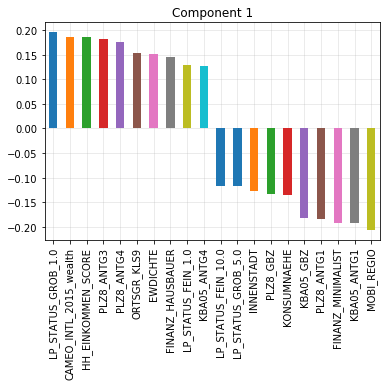

In [73]:
pca_result_component(azdias_filtered,pca,1)

ALTERSKATEGORIE_GROB
FINANZ_VORSORGER
ZABEOTYP_3
SEMIO_ERL
SEMIO_LUST
RETOURTYP_BK_S
W_KEIT_KIND_HH
CJT_GESAMTTYP_2.0
LP_STATUS_FEIN_1.0
FINANZTYP_5
ONLINE_AFFINITAET
SEMIO_RAT
SEMIO_KULT
FINANZ_ANLEGER
SEMIO_PFLICHT
SEMIO_TRADV
FINANZ_UNAUFFAELLIGER
SEMIO_REL
FINANZ_SPARER
PRAEGENDE_JUGENDJAHRE_decade


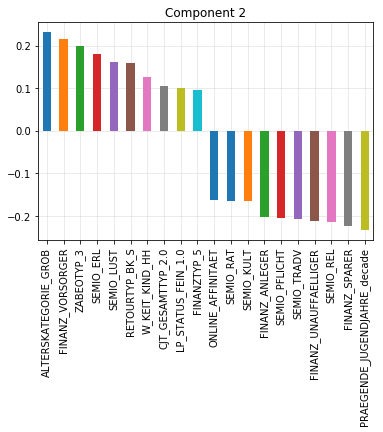

In [74]:
pca_result_component(azdias_filtered,pca,2)

SEMIO_VERT
SEMIO_FAM
SEMIO_SOZ
SEMIO_KULT
FINANZTYP_5
FINANZ_MINIMALIST
SHOPPER_TYP_0.0
ZABEOTYP_1
SEMIO_REL
SEMIO_MAT
LP_STATUS_FEIN_2.0
SHOPPER_TYP_2.0
FINANZTYP_1
FINANZ_ANLEGER
SEMIO_RAT
SEMIO_ERL
SEMIO_KRIT
SEMIO_DOM
SEMIO_KAEM
ANREDE_KZ


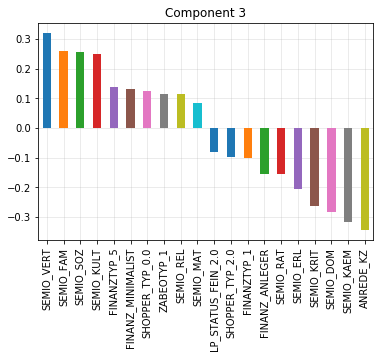

In [75]:
pca_result_component(azdias_filtered,pca,3)

PRAEGENDE_JUGENDJAHRE_movement
LP_STATUS_FEIN_10.0
LP_STATUS_GROB_5.0
EWDICHTE
ORTSGR_KLS9
ANZ_PERSONEN
SEMIO_DOM
ONLINE_AFFINITAET
SEMIO_KAEM
CAMEO_DEUG_2015_1
LP_STATUS_FEIN_4.0
LP_FAMILIE_GROB_1.0
LP_FAMILIE_FEIN_1.0
KKK
HH_EINKOMMEN_SCORE
INNENSTADT
BALLRAUM
LP_STATUS_FEIN_9.0
LP_STATUS_GROB_4.0
GREEN_AVANTGARDE


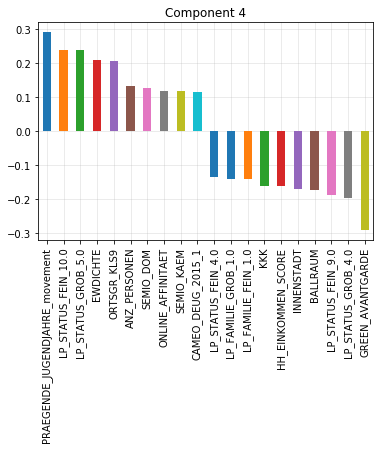

In [76]:
pca_result_component(azdias_filtered,pca,4)

ANZ_PERSONEN
LP_FAMILIE_GROB_5.0
LP_FAMILIE_FEIN_10.0
KKK
LP_FAMILIE_FEIN_11.0
REGIOTYP
FINANZTYP_6
LP_STATUS_FEIN_9.0
ONLINE_AFFINITAET
GREEN_AVANTGARDE
PLZ8_HHZ
FINANZ_UNAUFFAELLIGER
KBA13_ANZAHL_PKW
LP_STATUS_FEIN_3.0
PRAEGENDE_JUGENDJAHRE_movement
PLZ8_GBZ
LP_STATUS_GROB_2.0
W_KEIT_KIND_HH
LP_FAMILIE_FEIN_1.0
LP_FAMILIE_GROB_1.0


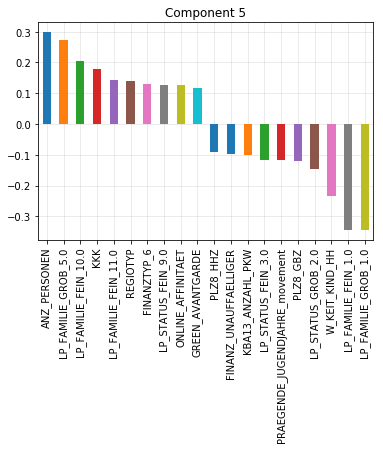

In [77]:
pca_result_component(azdias_filtered,pca,5)

### Discussion 2.3: Interpret Principal Components

The details above shows the information gained by each component

The first principal component increases with increasing low-income earners, German CAMEO: Wealth, Estimated household net income scores. The first principal component decreases with increasing Movement patterns, Number of 1-2 family houses in the microcell scores. Thus it suggests that these features moves together with the components.

The second is completely going towards Estimated age based on given name analysis and Financial typology scores



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [78]:
from sklearn.cluster import KMeans 

from sklearn.cluster import MiniBatchKMeans




score of  98223427.7127  for centers  2
score of  95026028.1095  for centers  3
score of  91569096.9347  for centers  4
score of  89884823.2519  for centers  5
score of  87747379.4356  for centers  6
score of  87119839.8338  for centers  7
score of  86272320.8319  for centers  8
score of  84972438.4589  for centers  9
score of  84763805.8367  for centers  10
score of  83743561.9501  for centers  11
score of  82682099.7051  for centers  12
score of  82285479.4999  for centers  13
score of  82263735.1648  for centers  14
score of  81688075.9949  for centers  15
score of  80563921.4271  for centers  16
score of  79808522.4139  for centers  17
score of  80107100.4036  for centers  18
score of  79232098.6786  for centers  19
score of  78826876.5696  for centers  20
score of  78983812.0944  for centers  21
score of  77569816.4457  for centers  22
score of  78514968.1363  for centers  23
score of  77406403.565  for centers  24
score of  76603419.4085  for centers  25
score of  75785572.0212  

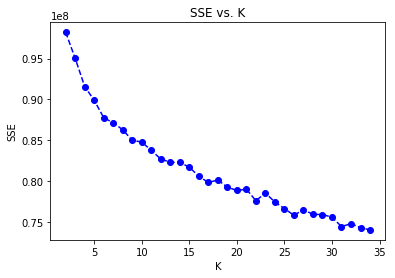

In [79]:
# Over a number of different cluster counts...


# run k-means clustering on the data and...
    
    
# compute the average within-cluster distances.
    
    
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding SSE for points to centers
    INPUT:
    data - the dataset you want to fit kmeans to
    center - the number of centers you want (the k value)
    OUTPUT:
    score - the SSE score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = MiniBatchKMeans(n_clusters=center, batch_size=int(data.shape[0]*0.20))
    # Then fit the model to your data using the fit method
    model = kmeans.fit(data)
    # Obtain a score related to the model fit
    score = np.abs(model.score(data))

    return score
    
scores = []
centers = list(range(2,35))
for center in centers:
    s = get_kmeans_score(pca_features, center)
    scores.append(s)
    print("score of ",s," for centers ", center)
plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [80]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.



In [81]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.


model = KMeans(29).fit(pca_features)

predict = model.predict(pca_features)

score = np.abs(model.score(pca_features))


### Discussion 3.1: Apply Clustering to General Population

From the graph 29 seems to be a good elbow point for clustering

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [82]:
# Load in the customer demographics data.
customers = pd.read_csv('./Udacity_CUSTOMERS_Subset.csv', ';')

In [83]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
print(feat_info.shape)

print(customers.shape)

customers_filtered  = clean_data(customers)

(85, 4)
(191652, 85)


/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)
/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


(133427, 75)
           attribute information_level         type missing_or_unknown
2          ANREDE_KZ            person  categorical             [-1,0]
3      CJT_GESAMTTYP            person  categorical                [0]
10         FINANZTYP            person  categorical               [-1]
12   GFK_URLAUBERTYP            person  categorical                 []
13  GREEN_AVANTGARDE            person  categorical                 []
17   LP_FAMILIE_FEIN            person  categorical                [0]
18   LP_FAMILIE_GROB            person  categorical                [0]
19    LP_STATUS_FEIN            person  categorical                [0]
20    LP_STATUS_GROB            person  categorical                [0]
21  NATIONALITAET_KZ            person  categorical             [-1,0]
38       SHOPPER_TYP            person  categorical               [-1]
39           SOHO_KZ            person  categorical               [-1]
41          VERS_TYP            person  categorical             

In [84]:
customers_filtered.shape

(133427, 191)

In [85]:
list(set(azdias_filtered.columns) - set(customers_filtered))

['GEBAEUDETYP_5.0']

In [86]:
azdias_filtered.columns

Index(['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST',
       'FINANZ_SPARER', 'FINANZ_VORSORGER', 'FINANZ_ANLEGER',
       'FINANZ_UNAUFFAELLIGER', 'FINANZ_HAUSBAUER', 'GREEN_AVANTGARDE',
       'HEALTH_TYP',
       ...
       'CAMEO_DEU_2015_8D', 'CAMEO_DEU_2015_9A', 'CAMEO_DEU_2015_9B',
       'CAMEO_DEU_2015_9C', 'CAMEO_DEU_2015_9D', 'CAMEO_DEU_2015_9E',
       'PRAEGENDE_JUGENDJAHRE_decade', 'PRAEGENDE_JUGENDJAHRE_movement',
       'CAMEO_INTL_2015_wealth', 'CAMEO_INTL_2015_lifestage'],
      dtype='object', length=192)

In [87]:
customers_filtered['GEBAEUDETYP_5.0'] = 1.0

customers_imputed = imputer.transform(customers_filtered)

customers_standardized = scaler.transform(customers_imputed)

pca_customers = pca.transform(customers_standardized)

kmeans_customers = model.predict(pca_customers)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [88]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
from collections import Counter

# Counter(words).values()

customer_dict = Counter(kmeans_customers)



gen_dict = Counter(predict)

print("\tCustomer data cluster --------- General Population cluster")
for key in sorted(gen_dict):
    if customer_dict[key] == 0:
        customer_dict[key] = 0
    print ("%s :\t %s :\t\t\t\t %s" % (key, customer_dict[key], gen_dict[key]))

	Customer data cluster --------- General Population cluster
0 :	 121 :				 20249
1 :	 477 :				 16771
2 :	 248 :				 34170
3 :	 884 :				 32736
4 :	 1678 :				 25200
5 :	 1610 :				 5792
6 :	 2835 :				 23004
7 :	 137 :				 25071
8 :	 48 :				 41479
9 :	 9550 :				 30285
10 :	 107 :				 32601
11 :	 1576 :				 31767
12 :	 48 :				 21010
13 :	 501 :				 28369
14 :	 324 :				 29325
15 :	 63 :				 23340
16 :	 27 :				 26830
17 :	 8635 :				 54622
18 :	 26928 :				 31986
19 :	 13 :				 21463
20 :	 1 :				 23898
21 :	 3 :				 35113
22 :	 2184 :				 36498
23 :	 184 :				 13514
24 :	 474 :				 18084
25 :	 65239 :				 5645
26 :	 2407 :				 31344
27 :	 964 :				 18791
28 :	 6161 :				 8152


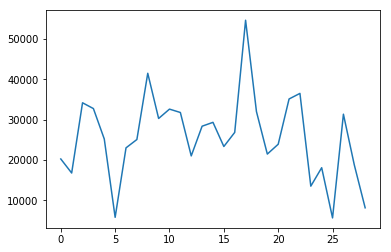

In [89]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?

lists = sorted(gen_dict.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

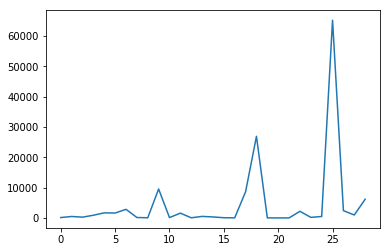

In [90]:
lists = sorted(customer_dict.items()) # sorted by key, return a list of tuples

x, y = zip(*lists) # unpack a list of pairs into two tuples

plt.plot(x, y)
plt.show()

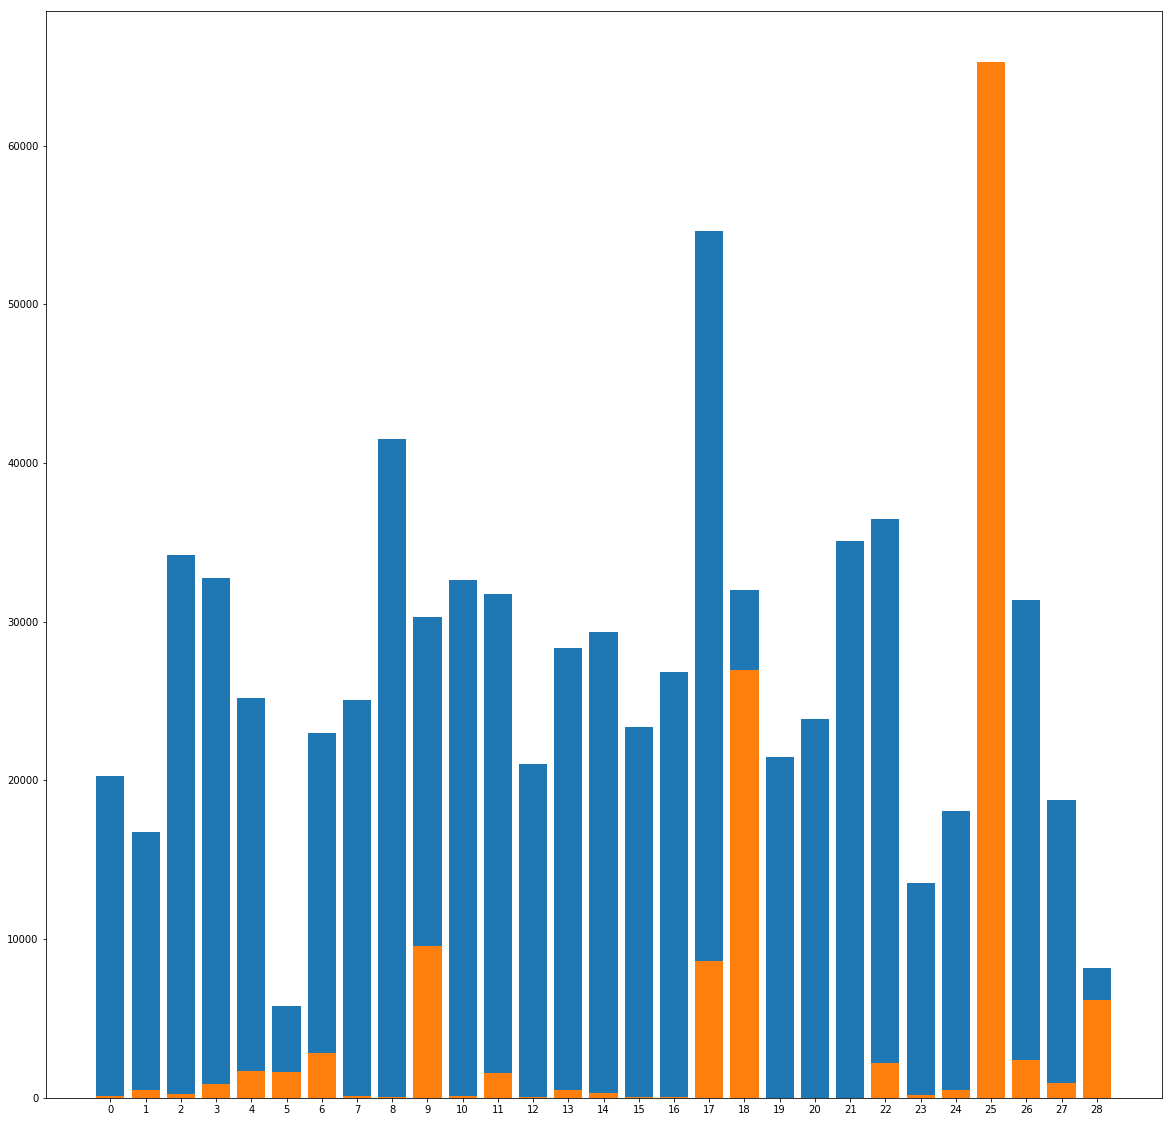

In [91]:
import collections
# print(customer_dict)

gen_dict = collections.OrderedDict(sorted(gen_dict.items()))
customer_dict = collections.OrderedDict(sorted(customer_dict.items()))

fig, ax1 = plt.subplots(figsize=(20, 20))
plt.bar(range(len(gen_dict)), list(gen_dict.values()), align='center')
plt.bar(range(len(customer_dict)), list(customer_dict.values()), align='center')
plt.xticks(range(len(gen_dict)), list((gen_dict.keys())))

fig.show()

In [92]:
import operator
diff_customer_proportions = list()

for key in gen_dict:
    diff_customer_proportions.append([key,customer_dict[key] - gen_dict[key]])
# print(diff_customer_proportions)
# diff_customer_proportions = customer_dict.values() - gen_dict.values()
diff_customer_proportions = sorted(diff_customer_proportions, key=lambda x: x[1], reverse = True)
# diff_customer_proportions.sort_values(ascending=False, inplace=True)
print('over-represented')
print(diff_customer_proportions[:3])
print('\nunder-represented')
print(diff_customer_proportions[-3:])

over-represented
[[25, 59594], [28, -1991], [5, -4182]]

under-represented
[[21, -35110], [8, -41431], [17, -45987]]


[ 4.00162829  2.82676983  0.52153488 -0.17322785  0.52215172 -1.13712289
  0.6445511   1.51821542 -0.28984642  0.11249539  0.01498736  0.35505976
 -1.61421847  0.51591688 -0.34653987  0.0835319  -0.75067115 -0.19304981
 -1.6075468   0.57722276  1.31315677 -0.03448104  0.92646927  0.49465404
 -0.1299298  -0.63337053 -0.66378927 -0.77342996  0.03231483 -0.54919548
  0.07627565 -0.16403886 -0.77437721 -0.23611645  0.52877343 -0.31790067
  0.0384328   0.75184493  0.45876423 -0.604476   -0.37845405 -0.50054253
  0.16990133  0.52256268  0.40229316 -0.24367491 -0.63890193 -0.14825812
 -0.60220753  1.94227466  0.15673979 -0.00424154  0.20991613  0.32739609
  0.40194902  0.71895086  0.51410218 -0.91145816 -0.68216998 -0.47540009
 -0.26072329 -0.22206062  0.33899712  0.56483685 -0.01151662 -0.02113043
 -0.24169585 -0.33623008 -0.62995486  0.27785748  0.12903813  0.35734523
  0.13648793 -0.19187821 -0.33945557]


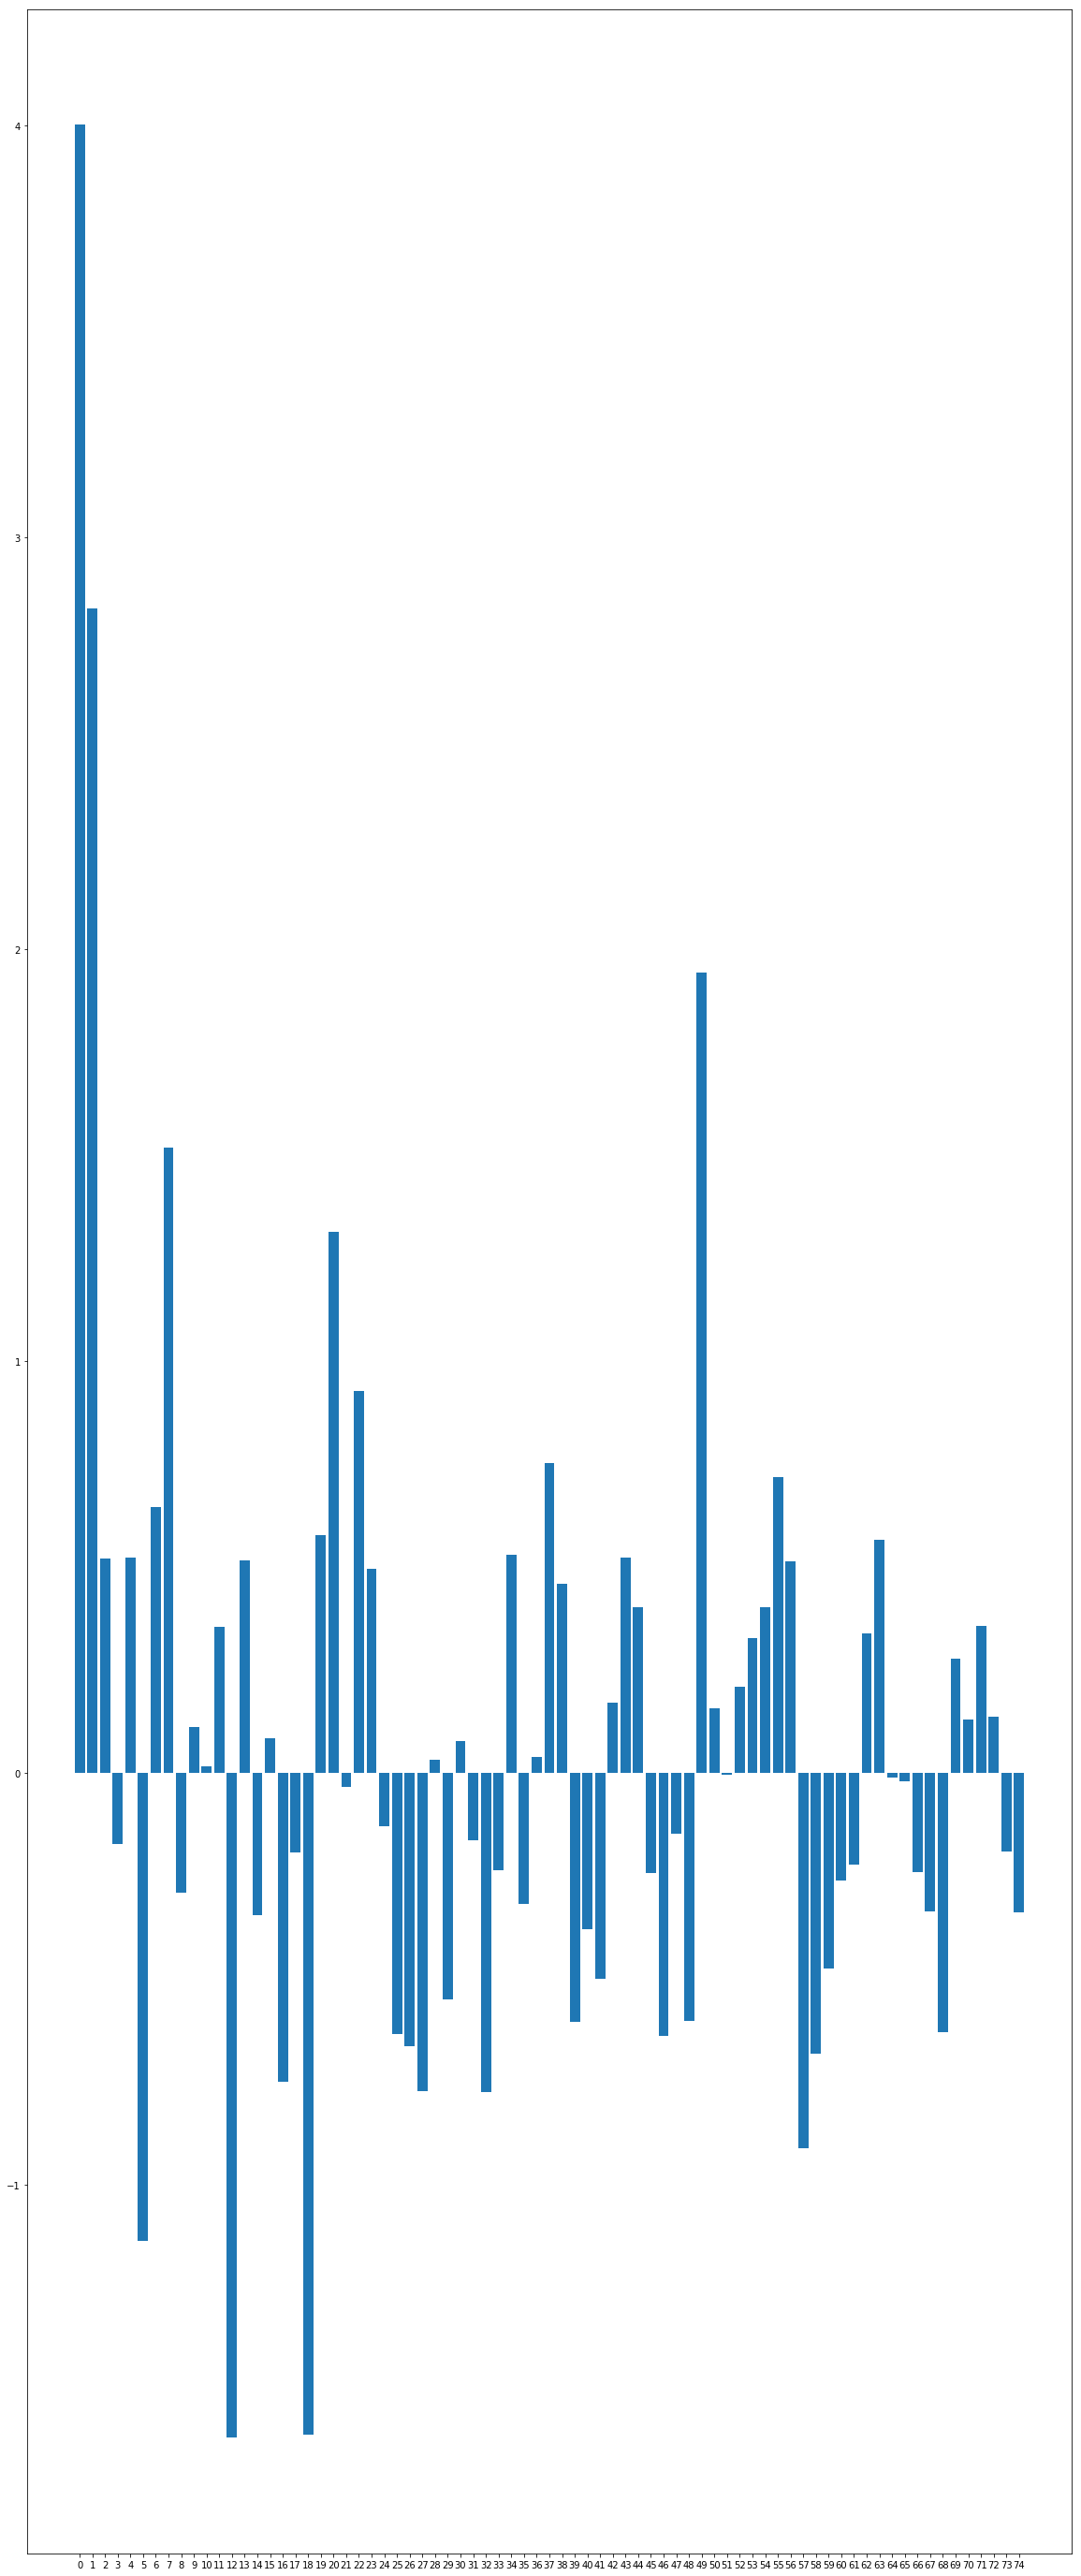

In [96]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?

print((model.cluster_centers_[1]))

fig, ax1 = plt.subplots(figsize=(20, 50))
plt.bar(range(len(model.cluster_centers_[1])), list(model.cluster_centers_[1]), align='center')
plt.xticks(range(len(model.cluster_centers_[1])), range(len(model.cluster_centers_[1])))

fig.show()

[ -3.46524290e+00  -3.32514963e+00  -1.99519683e-01  -1.71560674e+00
   1.93869237e+00  -1.13272935e+00   1.21423799e+00  -6.84087386e-01
  -9.90774143e-01  -1.23450037e-01  -5.09818177e-01   3.88189340e-01
  -1.52202023e-01  -3.79566683e-01  -3.44394138e-01   3.17216449e-01
  -8.41590937e-02  -5.57348968e-01   1.10790212e+00   1.81039858e-01
  -1.33865658e-01  -6.36995662e-02   5.65928512e-01   5.49201064e-01
   1.16470946e-01  -6.08953701e-03  -2.51755244e-01   1.19014951e-01
   2.63871428e-02   8.25791799e-02  -7.44605333e-02   3.08370710e-02
   4.68023650e-03  -5.04851367e-01  -1.03761225e-01   3.34420741e-01
  -2.85616220e-01   1.39171778e-01   4.27672821e-01   8.22468841e-02
   1.77757295e-01  -1.02108193e-01   2.22808030e-01   1.43837387e-01
   1.35751045e-01  -1.98757959e-02  -7.18145150e-02   4.57074946e-02
   6.57880937e-02   4.99894379e-02   1.84443133e-02  -1.24375469e-02
   1.80388623e-02  -1.47542573e-02  -8.45221837e-02   4.70034069e-02
   4.21970867e-02  -4.12533949e-02

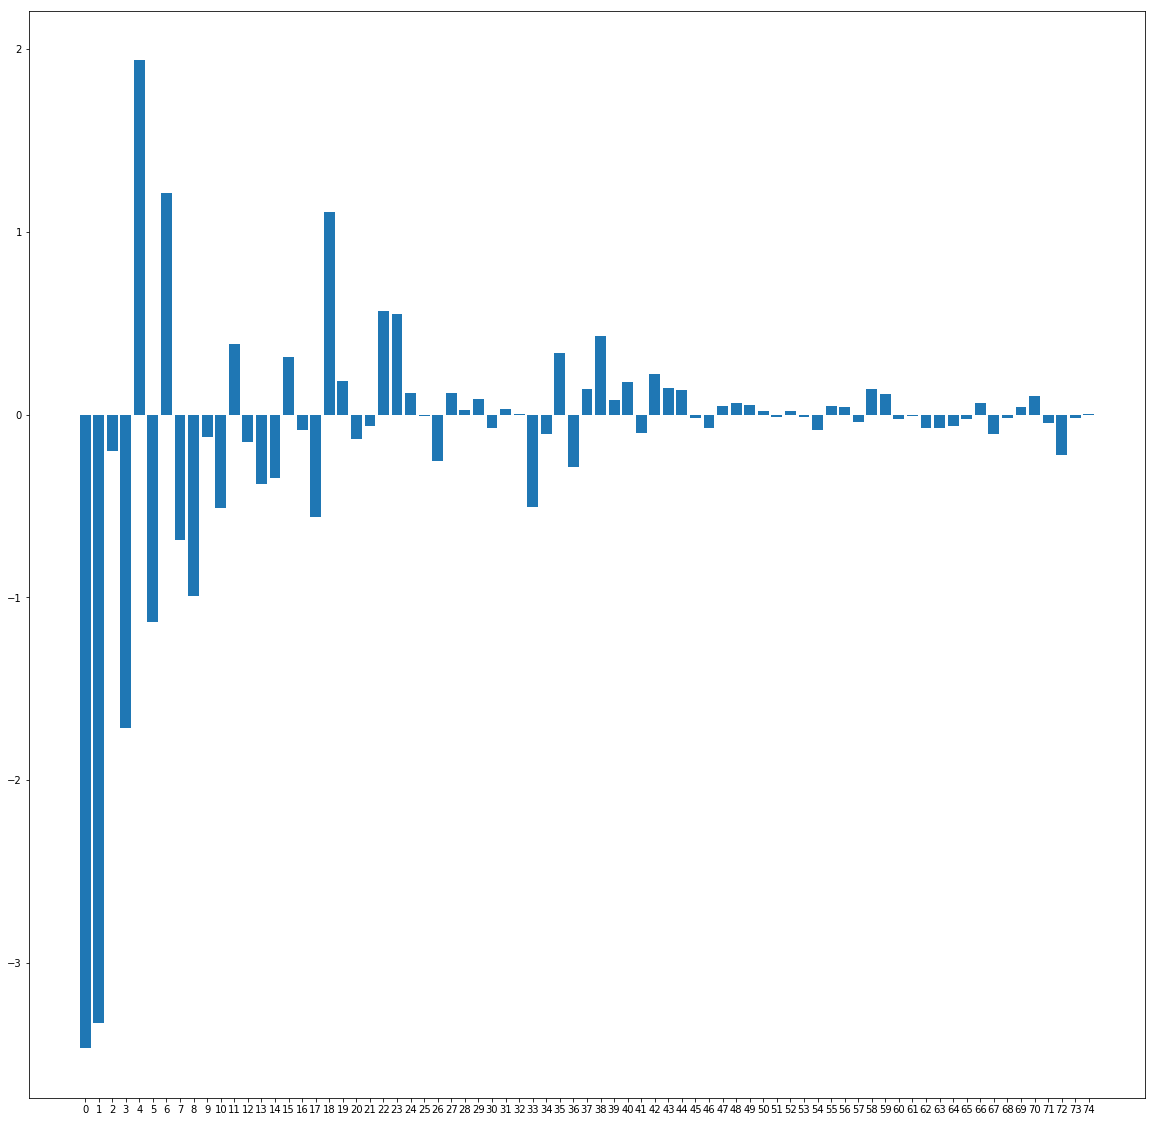

In [95]:
print(model.cluster_centers_[2])

fig, ax1 = plt.subplots(figsize=(20, 20))
plt.bar(range(len(model.cluster_centers_[2])), list(model.cluster_centers_[2]), align='center')
plt.xticks(range(len(model.cluster_centers_[2])), range(len(model.cluster_centers_[2])))

fig.show()

### Discussion 3.3: Compare Customer Data to Demographics Data

The mail-order sales company is most popular with people in clusters 25, 28, and 5, while it is least popular with people in clusters 17, 8, and 21.


The graph above suggests cluster 1 has a high impact on 1,2 components while high negative impact on 12th and 18th component. From the analysis above it suggests an incline towards low income earners.

Similarly cluster 2 has a high negative impact on 1,2 component which suggests a decline towards low income group.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.